In [7]:
# Import library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
import matplotlib.ticker as ticker
from sklearn import metrics
import math
import scipy.stats as stats
import itertools

In [8]:
# Load WEHA stock dataset
df_weha = pd.read_excel(
    'transportation_stocks.xlsx', sheet_name='WEHA.JK')
df_weha.set_index('Date', drop=True, inplace=True)
df_weha.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,183749939.0,185624939.0,183749939.0,183749939.0,181416550.0,505066.0
2011-04-04,182812439.0,183749939.0,182812439.0,182812439.0,180490952.0,736000.0
2011-04-05,181874939.0,182812439.0,181874939.0,181874939.0,179565369.0,777066.0
2011-04-06,180937439.0,181874939.0,180937439.0,180937439.0,178639771.0,595200.0
2011-04-07,180937439.0,180937439.0,180937439.0,180937439.0,178639771.0,661333.0


In [9]:
# Check datatypes
print(df_weha.dtypes)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [10]:
# Check missing value
print(df_weha.isnull().sum())

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64


In [11]:
# Fill missing value using mean imputation
for i in df_weha[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]:
    df_weha[i].fillna(df_weha[i].mean(), inplace=True)

print(df_weha.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


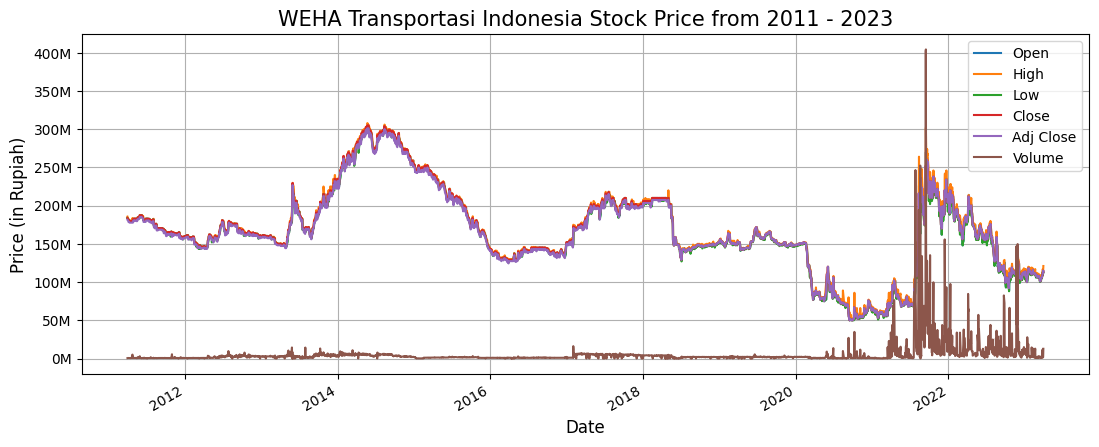

In [12]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize the historical prices from 2022 - 2023
df_weha.plot(figsize=(13,5))
plt.title('WEHA Transportasi Indonesia Stock Price from 2011 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

In [13]:
# Select the close price column as the target variable
target_col = 'Close'

# Create a new dataframe with only the target variable
target_df = pd.DataFrame(df_weha[target_col])

# Split the data into training and testing sets
train_size = int(len(target_df) * 0.9)
train_df = target_df[:train_size]
test_df = target_df[train_size:]
print('Training Set: ', train_df.shape)
print('Testing Set: ', test_df.shape)

Training Set:  (2682, 1)
Testing Set:  (298, 1)


In [14]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)
print('Training Scaled: ', train_scaled[0:5], '\n')
print('Testing Scaled: ', test_scaled[0:5])

Training Scaled:  [[0.52450956]
 [0.52083309]
 [0.51715662]
 [0.51348015]
 [0.51348015]] 

Testing Scaled:  [[0.62745098]
 [0.62745098]
 [0.64313725]
 [0.62745098]
 [0.62745098]]


In [15]:
# Define the sequence length and number of features
sequence_length = 60
num_features = 1

# Define the function to create sequences
def create_sequences(X, y, seq_length):
    X_sequences, y_sequences = [], []
    for i in range(seq_length, len(X)):
        X_sequences.append(X[i-seq_length:i, :])
        y_sequences.append(y[i, :])
    return np.array(X_sequences), np.array(y_sequences)

# Create training sequences and labels
X_train, y_train = create_sequences(train_scaled, train_scaled, sequence_length)

# Create testing sequences and labels
X_test, y_test = create_sequences(test_scaled, test_scaled, sequence_length)

# Print the shape of the training and testing sets
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (2622, 60, 1)
y train shape: (2622, 1)
X test shape: (238, 60, 1)
y test shape: (238, 1)


## LSTM Default Model

In [16]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features)))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_lstm_default.h5')

Epoch 1/10
24/24 [==============================] - 5s 61ms/step - loss: 0.0331 - val_loss: 0.0084
Epoch 2/10
24/24 [==============================] - 1s 26ms/step - loss: 0.0025 - val_loss: 0.0068
Epoch 3/10
24/24 [==============================] - 1s 27ms/step - loss: 0.0015 - val_loss: 0.0065
Epoch 4/10
24/24 [==============================] - 1s 28ms/step - loss: 0.0015 - val_loss: 0.0070
Epoch 5/10
24/24 [==============================] - 1s 26ms/step - loss: 0.0013 - val_loss: 0.0065
Epoch 6/10
24/24 [==============================] - 1s 28ms/step - loss: 0.0012 - val_loss: 0.0054
Epoch 7/10
24/24 [==============================] - 1s 30ms/step - loss: 0.0011 - val_loss: 0.0062
Epoch 8/10
24/24 [==============================] - 1s 30ms/step - loss: 8.9163e-04 - val_loss: 0.0053
Epoch 9/10
24/24 [==============================] - 1s 30ms/step - loss: 8.9945e-04 - val_loss: 0.0046
Epoch 10/10
24/24 [==============================] - 1s 31ms/step - loss: 8.2170e-04 - val_loss: 0.00

In [17]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 1s 8ms/step
Mean Absolute Error (MAE): 0.0253701
Mean Absolute Percentage Error (MAPE): 0.08396
Root Mean Squared Error (RMSE): 0.03376
Mean Squared Error (MSE): 0.00114
R-Squared (R2): 0.891818
T-Statistic 0.8217
P-Value 8.052734288612753e-16
Elapsed Time (min): 11.65


7/7 [==============================] - 0s 12ms/step


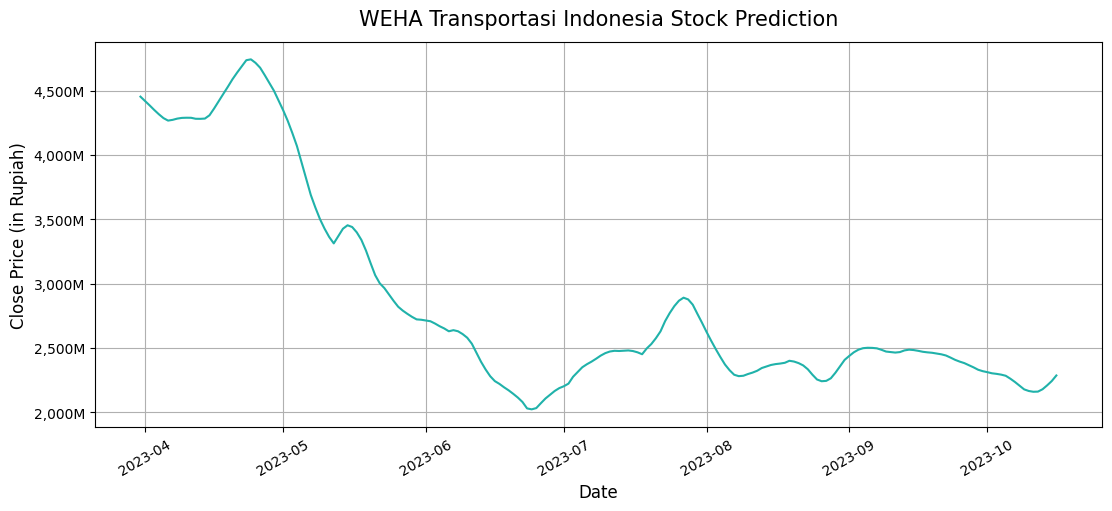

In [18]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Adam

In [19]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_linear_adam.h5')

Epoch 1/10
24/24 [==============================] - 15s 297ms/step - loss: 0.0361 - val_loss: 0.0104
Epoch 2/10
24/24 [==============================] - 5s 229ms/step - loss: 0.0047 - val_loss: 0.0063
Epoch 3/10
24/24 [==============================] - 5s 219ms/step - loss: 0.0026 - val_loss: 0.0055
Epoch 4/10
24/24 [==============================] - 5s 213ms/step - loss: 0.0024 - val_loss: 0.0052
Epoch 5/10
24/24 [==============================] - 5s 209ms/step - loss: 0.0021 - val_loss: 0.0051
Epoch 6/10
24/24 [==============================] - 5s 212ms/step - loss: 0.0018 - val_loss: 0.0052
Epoch 7/10
24/24 [==============================] - 5s 206ms/step - loss: 0.0017 - val_loss: 0.0050
Epoch 8/10
24/24 [==============================] - 5s 217ms/step - loss: 0.0018 - val_loss: 0.0052
Epoch 9/10
24/24 [==============================] - 5s 222ms/step - loss: 0.0018 - val_loss: 0.0049
Epoch 10/10
24/24 [==============================] - 5s 215ms/step - loss: 0.0016 - val_loss: 0.005

In [20]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 28ms/step
Mean Absolute Error (MAE): 0.0247843
Mean Absolute Percentage Error (MAPE): 0.08116
Root Mean Squared Error (RMSE): 0.03283
Mean Squared Error (MSE): 0.0010775
R-Squared (R2): 0.897742
T-Statistic 0.8278
P-Value 1.549584731838356e-15
Elapsed Time (min): 62.05


7/7 [==============================] - 0s 31ms/step


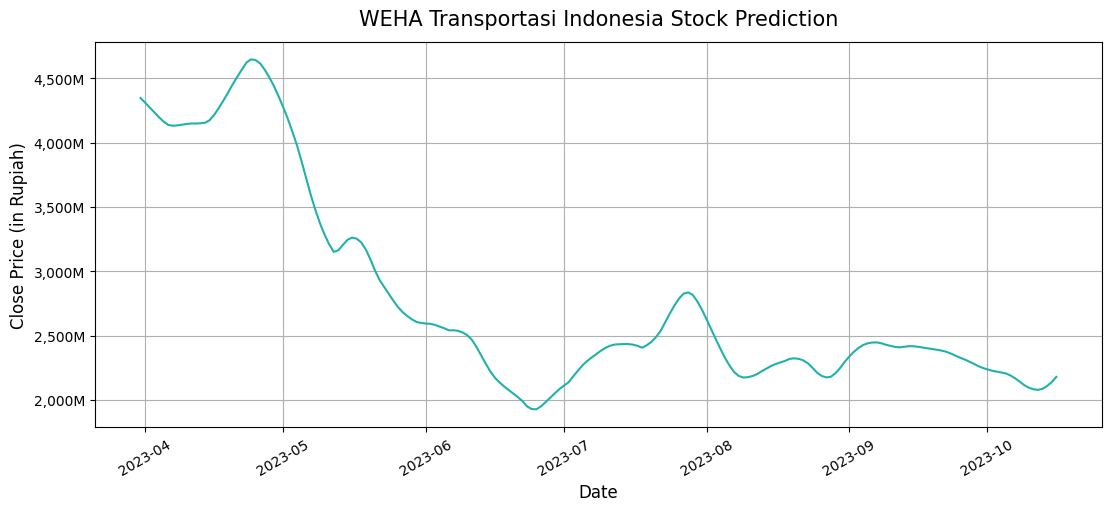

In [21]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaGrad

In [22]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_linear_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 15s 349ms/step - loss: 0.1041 - val_loss: 0.0417
Epoch 2/10
24/24 [==============================] - 6s 237ms/step - loss: 0.0321 - val_loss: 0.0328
Epoch 3/10
24/24 [==============================] - 6s 245ms/step - loss: 0.0193 - val_loss: 0.0327
Epoch 4/10
24/24 [==============================] - 6s 247ms/step - loss: 0.0163 - val_loss: 0.0323
Epoch 5/10
24/24 [==============================] - 6s 263ms/step - loss: 0.0153 - val_loss: 0.0310
Epoch 6/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0152 - val_loss: 0.0295
Epoch 7/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0143 - val_loss: 0.0281
Epoch 8/10
24/24 [==============================] - 6s 262ms/step - loss: 0.0140 - val_loss: 0.0266
Epoch 9/10
24/24 [==============================] - 6s 252ms/step - loss: 0.0134 - val_loss: 0.0252
Epoch 10/10
24/24 [==============================] - 6s 251ms/step - loss: 0.0126 - val_loss: 0.024

In [23]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 32ms/step
Mean Absolute Error (MAE): 0.0996529
Mean Absolute Percentage Error (MAPE): 0.39217
Root Mean Squared Error (RMSE): 0.10862
Mean Squared Error (MSE): 0.0117979
R-Squared (R2): -0.119607
T-Statistic 0.8179
P-Value 5.426574280704207e-16
Elapsed Time (min): 70.43


7/7 [==============================] - 0s 36ms/step


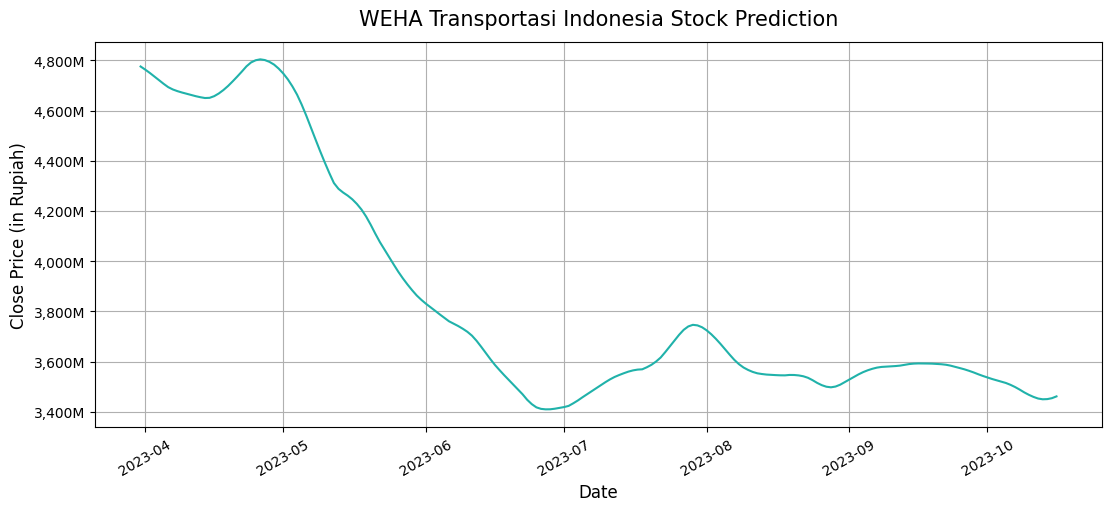

In [24]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Nadam

In [25]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_linear_nadam.h5')

Epoch 1/10
24/24 [==============================] - 17s 352ms/step - loss: 0.0263 - val_loss: 0.0072
Epoch 2/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0032 - val_loss: 0.0063
Epoch 3/10
24/24 [==============================] - 6s 262ms/step - loss: 0.0025 - val_loss: 0.0062
Epoch 4/10
24/24 [==============================] - 6s 266ms/step - loss: 0.0024 - val_loss: 0.0059
Epoch 5/10
24/24 [==============================] - 7s 281ms/step - loss: 0.0020 - val_loss: 0.0057
Epoch 6/10
24/24 [==============================] - 7s 282ms/step - loss: 0.0020 - val_loss: 0.0059
Epoch 7/10
24/24 [==============================] - 7s 274ms/step - loss: 0.0019 - val_loss: 0.0055
Epoch 8/10
24/24 [==============================] - 7s 282ms/step - loss: 0.0018 - val_loss: 0.0054
Epoch 9/10
24/24 [==============================] - 7s 293ms/step - loss: 0.0016 - val_loss: 0.0053
Epoch 10/10
24/24 [==============================] - 7s 291ms/step - loss: 0.0017 - val_loss: 0.005

In [26]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 31ms/step
Mean Absolute Error (MAE): 0.0254886
Mean Absolute Percentage Error (MAPE): 0.08243
Root Mean Squared Error (RMSE): 0.03348
Mean Squared Error (MSE): 0.0011212
R-Squared (R2): 0.893601
T-Statistic 0.8305
P-Value 2.0749348945162073e-15
Elapsed Time (min): 77.96


7/7 [==============================] - 0s 31ms/step


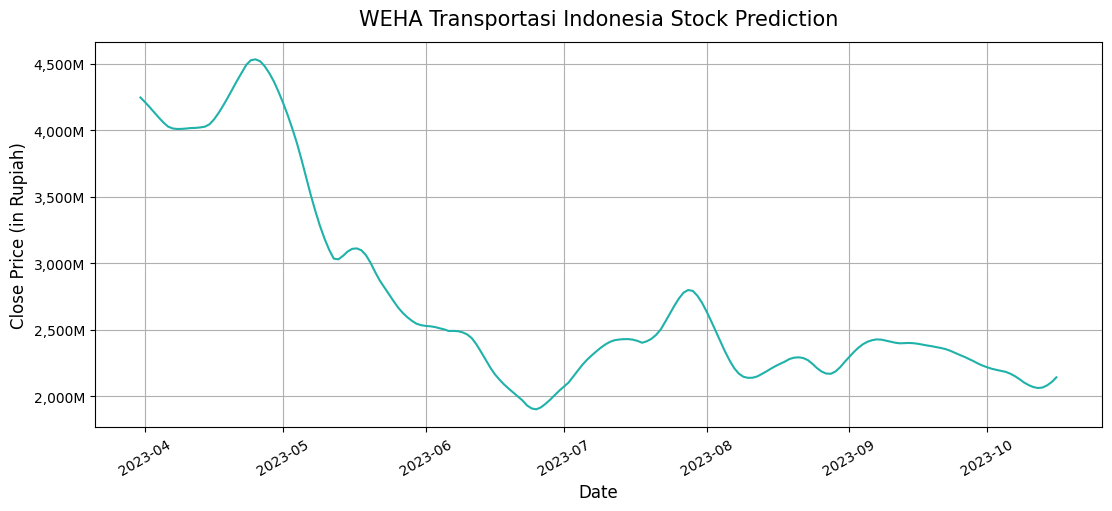

In [27]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - RMSProp

In [28]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_linear_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 15s 360ms/step - loss: 0.0245 - val_loss: 0.0088
Epoch 2/10
24/24 [==============================] - 5s 200ms/step - loss: 0.0072 - val_loss: 0.0101
Epoch 3/10
24/24 [==============================] - 5s 226ms/step - loss: 0.0070 - val_loss: 0.0252
Epoch 4/10
24/24 [==============================] - 6s 235ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 5/10
24/24 [==============================] - 5s 222ms/step - loss: 0.0047 - val_loss: 0.0099
Epoch 6/10
24/24 [==============================] - 5s 212ms/step - loss: 0.0047 - val_loss: 0.0058
Epoch 7/10
24/24 [==============================] - 5s 212ms/step - loss: 0.0042 - val_loss: 0.0113
Epoch 8/10
24/24 [==============================] - 5s 225ms/step - loss: 0.0038 - val_loss: 0.0062
Epoch 9/10
24/24 [==============================] - 5s 224ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 10/10
24/24 [==============================] - 5s 216ms/step - loss: 0.0032 - val_loss: 0.004

In [29]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 30ms/step
Mean Absolute Error (MAE): 0.0376284
Mean Absolute Percentage Error (MAPE): 0.12874
Root Mean Squared Error (RMSE): 0.04657
Mean Squared Error (MSE): 0.0021684
R-Squared (R2): 0.794225
T-Statistic 0.8268
P-Value 1.383875970597853e-15
Elapsed Time (min): 62.99


7/7 [==============================] - 0s 31ms/step


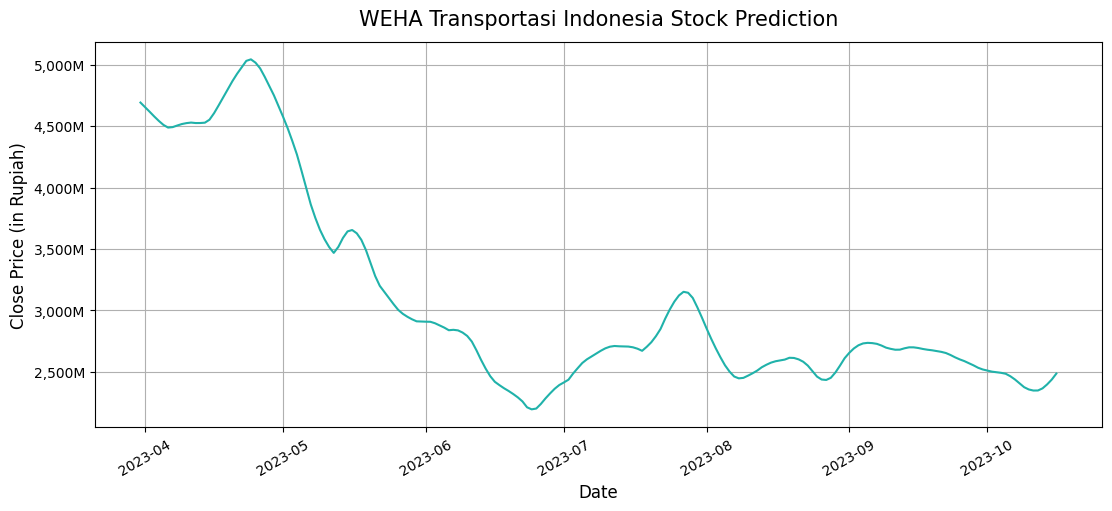

In [30]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaDelta

In [31]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_linear_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 13s 273ms/step - loss: 0.2704 - val_loss: 0.1691
Epoch 2/10
24/24 [==============================] - 5s 209ms/step - loss: 0.2663 - val_loss: 0.1666
Epoch 3/10
24/24 [==============================] - 5s 216ms/step - loss: 0.2627 - val_loss: 0.1642
Epoch 4/10
24/24 [==============================] - 5s 222ms/step - loss: 0.2585 - val_loss: 0.1617
Epoch 5/10
24/24 [==============================] - 6s 232ms/step - loss: 0.2546 - val_loss: 0.1592
Epoch 6/10
24/24 [==============================] - 5s 224ms/step - loss: 0.2505 - val_loss: 0.1567
Epoch 7/10
24/24 [==============================] - 5s 227ms/step - loss: 0.2464 - val_loss: 0.1541
Epoch 8/10
24/24 [==============================] - 6s 263ms/step - loss: 0.2423 - val_loss: 0.1516
Epoch 9/10
24/24 [==============================] - 6s 249ms/step - loss: 0.2367 - val_loss: 0.1490
Epoch 10/10
24/24 [==============================] - 6s 241ms/step - loss: 0.2330 - val_loss: 0.146

In [32]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 32ms/step
Mean Absolute Error (MAE): 0.2749349
Mean Absolute Percentage Error (MAPE): 0.88865
Root Mean Squared Error (RMSE): 0.29086
Mean Squared Error (MSE): 0.0845976
R-Squared (R2): -7.028241
T-Statistic 0.8147
P-Value 3.8859187584375687e-16
Elapsed Time (min): 64.08


7/7 [==============================] - 0s 32ms/step


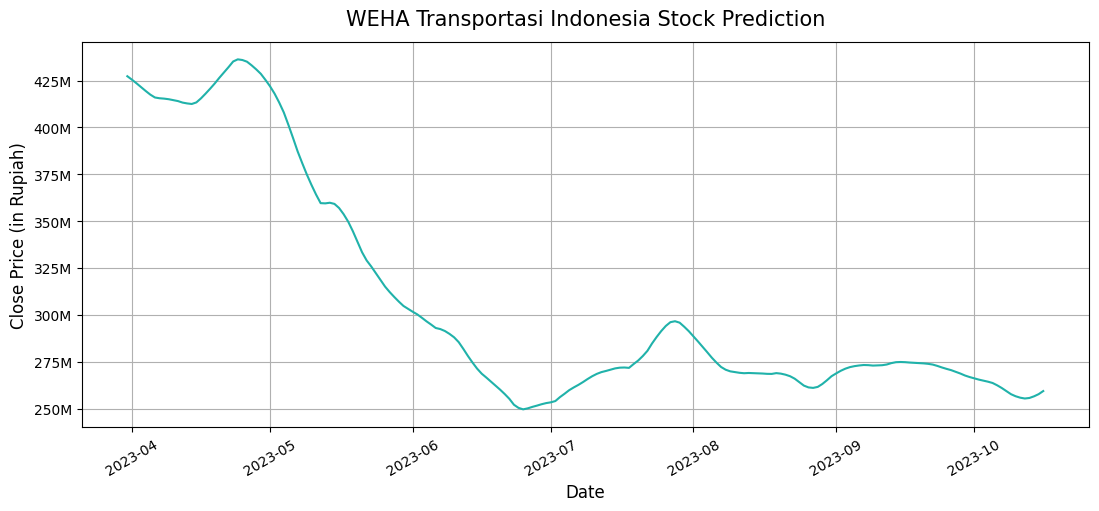

In [33]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - SGD

In [34]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_linear_sgd.h5')

Epoch 1/10
24/24 [==============================] - 24s 659ms/step - loss: 0.0534 - val_loss: 0.0533
Epoch 2/10
24/24 [==============================] - 16s 678ms/step - loss: 0.0219 - val_loss: 0.0418
Epoch 3/10
24/24 [==============================] - 15s 622ms/step - loss: 0.0182 - val_loss: 0.0349
Epoch 4/10
24/24 [==============================] - 14s 573ms/step - loss: 0.0149 - val_loss: 0.0291
Epoch 5/10
24/24 [==============================] - 13s 523ms/step - loss: 0.0125 - val_loss: 0.0229
Epoch 6/10
24/24 [==============================] - 13s 534ms/step - loss: 0.0102 - val_loss: 0.0185
Epoch 7/10
24/24 [==============================] - 14s 566ms/step - loss: 0.0085 - val_loss: 0.0150
Epoch 8/10
24/24 [==============================] - 14s 584ms/step - loss: 0.0073 - val_loss: 0.0125
Epoch 9/10
24/24 [==============================] - 15s 619ms/step - loss: 0.0062 - val_loss: 0.0104
Epoch 10/10
24/24 [==============================] - 14s 568ms/step - loss: 0.0051 - val_lo

In [35]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 41ms/step
Mean Absolute Error (MAE): 0.0479684
Mean Absolute Percentage Error (MAPE): 0.17974
Root Mean Squared Error (RMSE): 0.05509
Mean Squared Error (MSE): 0.0030352
R-Squared (R2): 0.711965
T-Statistic 0.8184
P-Value 5.733499316119763e-16
Elapsed Time (min): 151.44


7/7 [==============================] - 0s 42ms/step


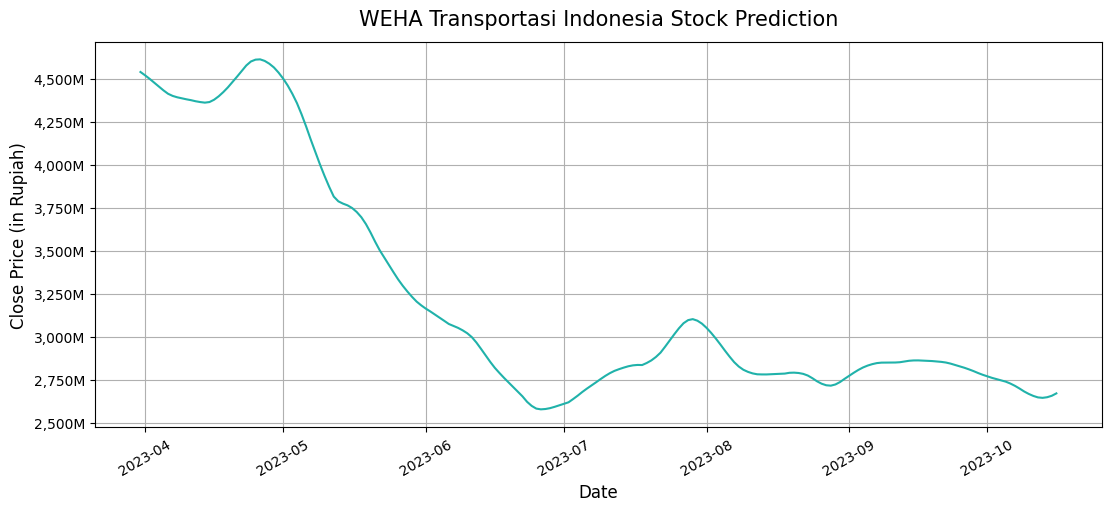

In [36]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaMax

In [37]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_linear_adamax.h5')

Epoch 1/10
24/24 [==============================] - 23s 669ms/step - loss: 0.0384 - val_loss: 0.0096
Epoch 2/10
24/24 [==============================] - 14s 608ms/step - loss: 0.0052 - val_loss: 0.0079
Epoch 3/10
24/24 [==============================] - 13s 553ms/step - loss: 0.0039 - val_loss: 0.0067
Epoch 4/10
24/24 [==============================] - 14s 588ms/step - loss: 0.0032 - val_loss: 0.0063
Epoch 5/10
24/24 [==============================] - 14s 590ms/step - loss: 0.0029 - val_loss: 0.0062
Epoch 6/10
24/24 [==============================] - 14s 571ms/step - loss: 0.0026 - val_loss: 0.0063
Epoch 7/10
24/24 [==============================] - 15s 632ms/step - loss: 0.0025 - val_loss: 0.0062
Epoch 8/10
24/24 [==============================] - 14s 586ms/step - loss: 0.0024 - val_loss: 0.0061
Epoch 9/10
24/24 [==============================] - 14s 574ms/step - loss: 0.0025 - val_loss: 0.0061
Epoch 10/10
24/24 [==============================] - 15s 611ms/step - loss: 0.0023 - val_lo

In [38]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 36ms/step
Mean Absolute Error (MAE): 0.0269593
Mean Absolute Percentage Error (MAPE): 0.08949
Root Mean Squared Error (RMSE): 0.03499
Mean Squared Error (MSE): 0.001224
R-Squared (R2): 0.883845
T-Statistic 0.8208
P-Value 7.341323492312483e-16
Elapsed Time (min): 151.92


7/7 [==============================] - 0s 39ms/step


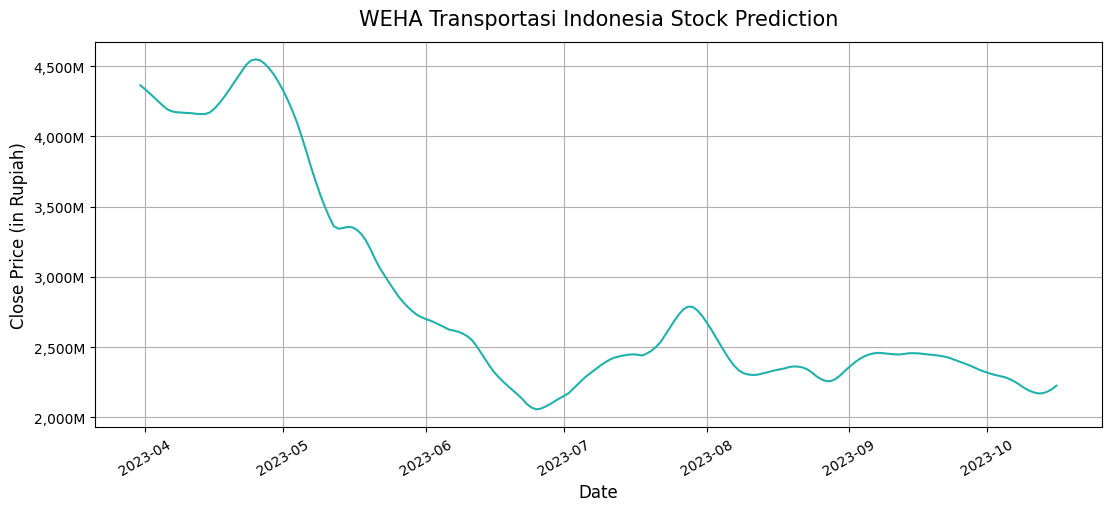

In [39]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Adam

In [40]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_relu_adam.h5')

Epoch 1/10
24/24 [==============================] - 23s 591ms/step - loss: 0.0470 - val_loss: 0.0118
Epoch 2/10
24/24 [==============================] - 13s 553ms/step - loss: 0.0055 - val_loss: 0.0073
Epoch 3/10
24/24 [==============================] - 13s 541ms/step - loss: 0.0031 - val_loss: 0.0067
Epoch 4/10
24/24 [==============================] - 12s 513ms/step - loss: 0.0025 - val_loss: 0.0065
Epoch 5/10
24/24 [==============================] - 13s 533ms/step - loss: 0.0023 - val_loss: 0.0068
Epoch 6/10
24/24 [==============================] - 13s 538ms/step - loss: 0.0022 - val_loss: 0.0060
Epoch 7/10
24/24 [==============================] - 13s 523ms/step - loss: 0.0020 - val_loss: 0.0060
Epoch 8/10
24/24 [==============================] - 12s 508ms/step - loss: 0.0021 - val_loss: 0.0066
Epoch 9/10
24/24 [==============================] - 13s 547ms/step - loss: 0.0019 - val_loss: 0.0058
Epoch 10/10
24/24 [==============================] - 13s 541ms/step - loss: 0.0018 - val_lo

In [41]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 45ms/step
Mean Absolute Error (MAE): 0.0270935
Mean Absolute Percentage Error (MAPE): 0.08845
Root Mean Squared Error (RMSE): 0.03559
Mean Squared Error (MSE): 0.0012668
R-Squared (R2): 0.879783
T-Statistic 0.8259
P-Value 1.25612243808646e-15
Elapsed Time (min): 139.2


7/7 [==============================] - 0s 44ms/step


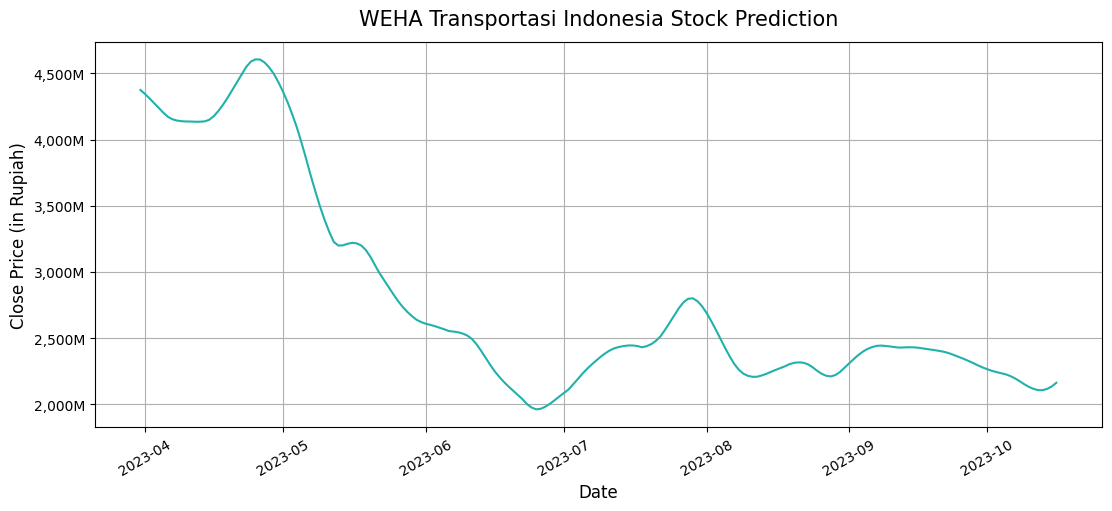

In [42]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaGrad

In [43]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_relu_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 17s 357ms/step - loss: 0.2291 - val_loss: 0.1165
Epoch 2/10
24/24 [==============================] - 7s 295ms/step - loss: 0.1675 - val_loss: 0.0902
Epoch 3/10
24/24 [==============================] - 7s 288ms/step - loss: 0.1289 - val_loss: 0.0725
Epoch 4/10
24/24 [==============================] - 7s 282ms/step - loss: 0.0981 - val_loss: 0.0600
Epoch 5/10
24/24 [==============================] - 6s 238ms/step - loss: 0.0746 - val_loss: 0.0500
Epoch 6/10
24/24 [==============================] - 6s 235ms/step - loss: 0.0547 - val_loss: 0.0440
Epoch 7/10
24/24 [==============================] - 5s 220ms/step - loss: 0.0423 - val_loss: 0.0411
Epoch 8/10
24/24 [==============================] - 5s 222ms/step - loss: 0.0339 - val_loss: 0.0402
Epoch 9/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0289 - val_loss: 0.0402
Epoch 10/10
24/24 [==============================] - 5s 227ms/step - loss: 0.0260 - val_loss: 0.040

In [44]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 32ms/step
Mean Absolute Error (MAE): 0.1044148
Mean Absolute Percentage Error (MAPE): 0.42142
Root Mean Squared Error (RMSE): 0.11713
Mean Squared Error (MSE): 0.0137194
R-Squared (R2): -0.301959
T-Statistic 0.8198
P-Value 6.644821534675072e-16
Elapsed Time (min): 72.65


7/7 [==============================] - 0s 33ms/step


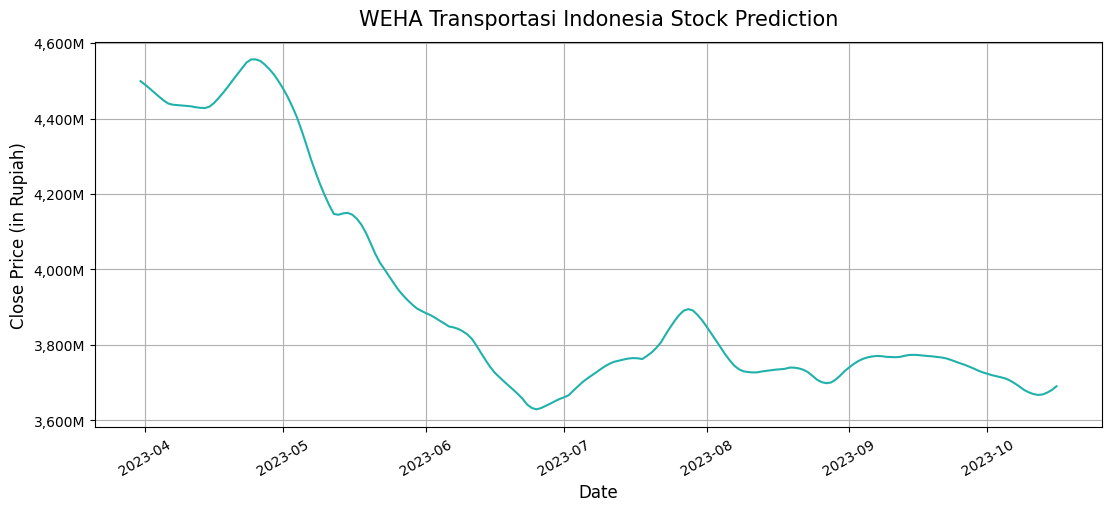

In [45]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Nadam

In [46]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_relu_nadam.h5')

Epoch 1/10
24/24 [==============================] - 18s 340ms/step - loss: 0.0503 - val_loss: 0.0097
Epoch 2/10
24/24 [==============================] - 6s 237ms/step - loss: 0.0036 - val_loss: 0.0084
Epoch 3/10
24/24 [==============================] - 6s 230ms/step - loss: 0.0031 - val_loss: 0.0084
Epoch 4/10
24/24 [==============================] - 6s 245ms/step - loss: 0.0026 - val_loss: 0.0074
Epoch 5/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0025 - val_loss: 0.0073
Epoch 6/10
24/24 [==============================] - 6s 234ms/step - loss: 0.0022 - val_loss: 0.0073
Epoch 7/10
24/24 [==============================] - 6s 271ms/step - loss: 0.0021 - val_loss: 0.0067
Epoch 8/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0020 - val_loss: 0.0067
Epoch 9/10
24/24 [==============================] - 5s 228ms/step - loss: 0.0019 - val_loss: 0.0063
Epoch 10/10
24/24 [==============================] - 6s 240ms/step - loss: 0.0019 - val_loss: 0.006

In [47]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 32ms/step
Mean Absolute Error (MAE): 0.0292362
Mean Absolute Percentage Error (MAPE): 0.09586
Root Mean Squared Error (RMSE): 0.03888
Mean Squared Error (MSE): 0.0015118
R-Squared (R2): 0.856534
T-Statistic 0.8229
P-Value 9.193493380382019e-16
Elapsed Time (min): 71.62


7/7 [==============================] - 0s 33ms/step


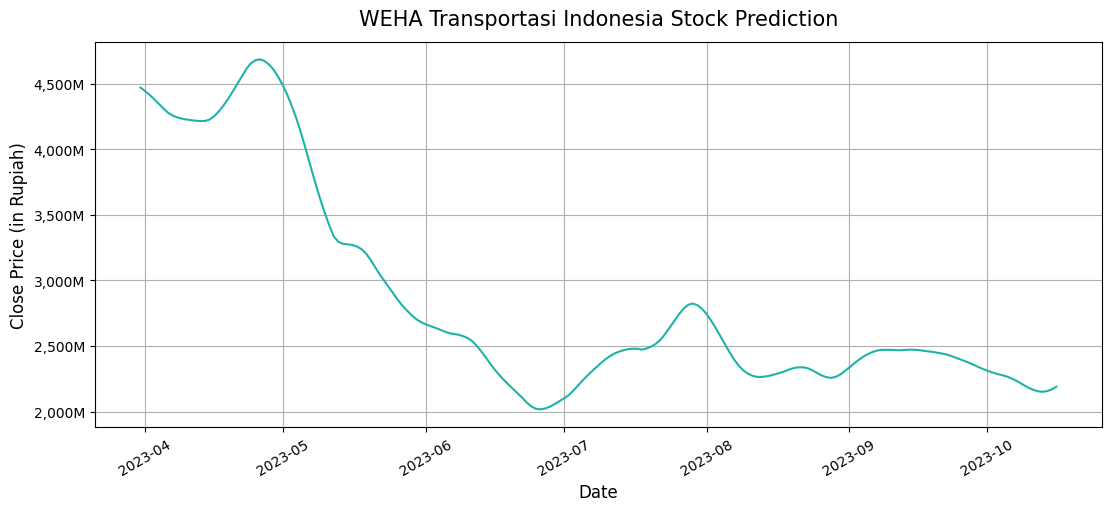

In [48]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - RMSProp

In [49]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_relu_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 14s 305ms/step - loss: 0.0302 - val_loss: 0.0110
Epoch 2/10
24/24 [==============================] - 5s 215ms/step - loss: 0.0078 - val_loss: 0.0127
Epoch 3/10
24/24 [==============================] - 6s 234ms/step - loss: 0.0076 - val_loss: 0.0106
Epoch 4/10
24/24 [==============================] - 6s 251ms/step - loss: 0.0061 - val_loss: 0.0087
Epoch 5/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 6/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0043 - val_loss: 0.0066
Epoch 7/10
24/24 [==============================] - 7s 275ms/step - loss: 0.0049 - val_loss: 0.0054
Epoch 8/10
24/24 [==============================] - 6s 269ms/step - loss: 0.0036 - val_loss: 0.0051
Epoch 9/10
24/24 [==============================] - 7s 277ms/step - loss: 0.0039 - val_loss: 0.0049
Epoch 10/10
24/24 [==============================] - 7s 277ms/step - loss: 0.0030 - val_loss: 0.004

In [50]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)  

8/8 [==============================] - 2s 41ms/step
Mean Absolute Error (MAE): 0.0294683
Mean Absolute Percentage Error (MAPE): 0.10088
Root Mean Squared Error (RMSE): 0.03763
Mean Squared Error (MSE): 0.0014157
R-Squared (R2): 0.865647
T-Statistic 0.827
P-Value 1.41994337464577e-15
Elapsed Time (min): 70.42


7/7 [==============================] - 0s 38ms/step


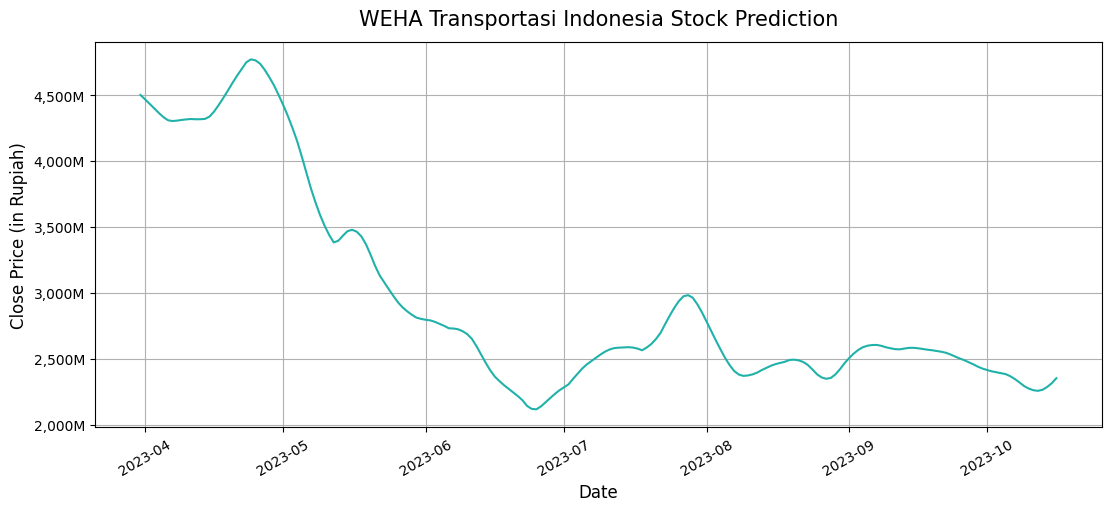

In [51]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaDelta

In [52]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_relu_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 15s 303ms/step - loss: 0.2578 - val_loss: 0.1604
Epoch 2/10
24/24 [==============================] - 5s 222ms/step - loss: 0.2539 - val_loss: 0.1587
Epoch 3/10
24/24 [==============================] - 5s 220ms/step - loss: 0.2524 - val_loss: 0.1569
Epoch 4/10
24/24 [==============================] - 5s 224ms/step - loss: 0.2486 - val_loss: 0.1551
Epoch 5/10
24/24 [==============================] - 6s 250ms/step - loss: 0.2458 - val_loss: 0.1532
Epoch 6/10
24/24 [==============================] - 6s 251ms/step - loss: 0.2431 - val_loss: 0.1512
Epoch 7/10
24/24 [==============================] - 6s 254ms/step - loss: 0.2401 - val_loss: 0.1490
Epoch 8/10
24/24 [==============================] - 6s 232ms/step - loss: 0.2377 - val_loss: 0.1468
Epoch 9/10
24/24 [==============================] - 6s 238ms/step - loss: 0.2335 - val_loss: 0.1445
Epoch 10/10
24/24 [==============================] - 5s 226ms/step - loss: 0.2308 - val_loss: 0.142

In [53]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)  

8/8 [==============================] - 2s 36ms/step
Mean Absolute Error (MAE): 0.2712285
Mean Absolute Percentage Error (MAPE): 0.87701
Root Mean Squared Error (RMSE): 0.28682
Mean Squared Error (MSE): 0.0822644
R-Squared (R2): -6.806816
T-Statistic 0.8195
P-Value 6.38210367817231e-16
Elapsed Time (min): 67.45


7/7 [==============================] - 0s 34ms/step


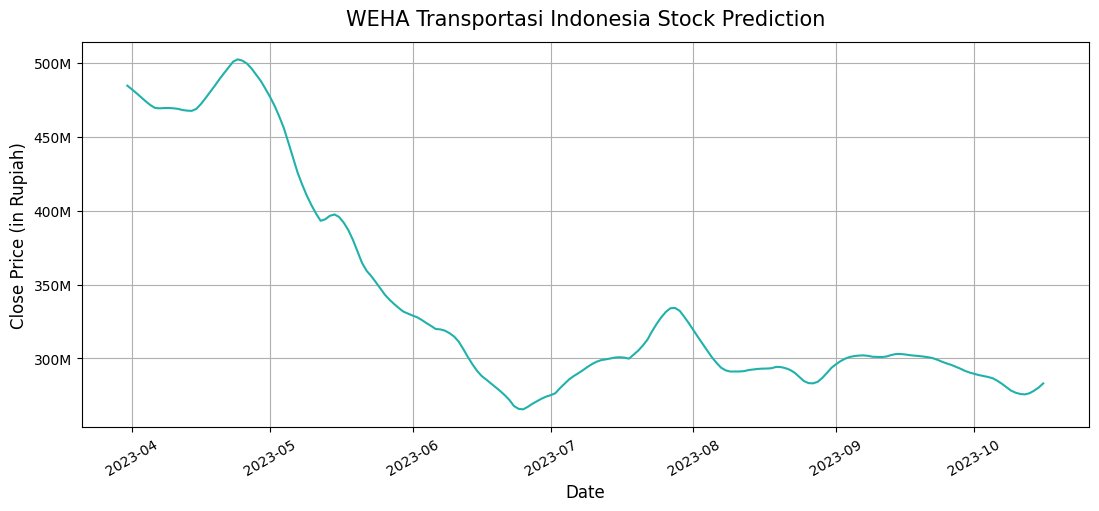

In [54]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - SGD

In [55]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_relu_sgd.h5')

Epoch 1/10
24/24 [==============================] - 14s 319ms/step - loss: 0.0962 - val_loss: 0.0575
Epoch 2/10
24/24 [==============================] - 6s 231ms/step - loss: 0.0297 - val_loss: 0.0594
Epoch 3/10
24/24 [==============================] - 6s 245ms/step - loss: 0.0260 - val_loss: 0.0558
Epoch 4/10
24/24 [==============================] - 6s 257ms/step - loss: 0.0238 - val_loss: 0.0480
Epoch 5/10
24/24 [==============================] - 6s 247ms/step - loss: 0.0210 - val_loss: 0.0432
Epoch 6/10
24/24 [==============================] - 6s 231ms/step - loss: 0.0193 - val_loss: 0.0374
Epoch 7/10
24/24 [==============================] - 6s 238ms/step - loss: 0.0166 - val_loss: 0.0316
Epoch 8/10
24/24 [==============================] - 7s 303ms/step - loss: 0.0150 - val_loss: 0.0276
Epoch 9/10
24/24 [==============================] - 10s 404ms/step - loss: 0.0129 - val_loss: 0.0230
Epoch 10/10
24/24 [==============================] - 7s 291ms/step - loss: 0.0112 - val_loss: 0.01

In [56]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 54ms/step
Mean Absolute Error (MAE): 0.0933411
Mean Absolute Percentage Error (MAPE): 0.36469
Root Mean Squared Error (RMSE): 0.10142
Mean Squared Error (MSE): 0.0102868
R-Squared (R2): 0.023787
T-Statistic 0.8182
P-Value 5.573934720120406e-16
Elapsed Time (min): 73.97


7/7 [==============================] - 0s 50ms/step


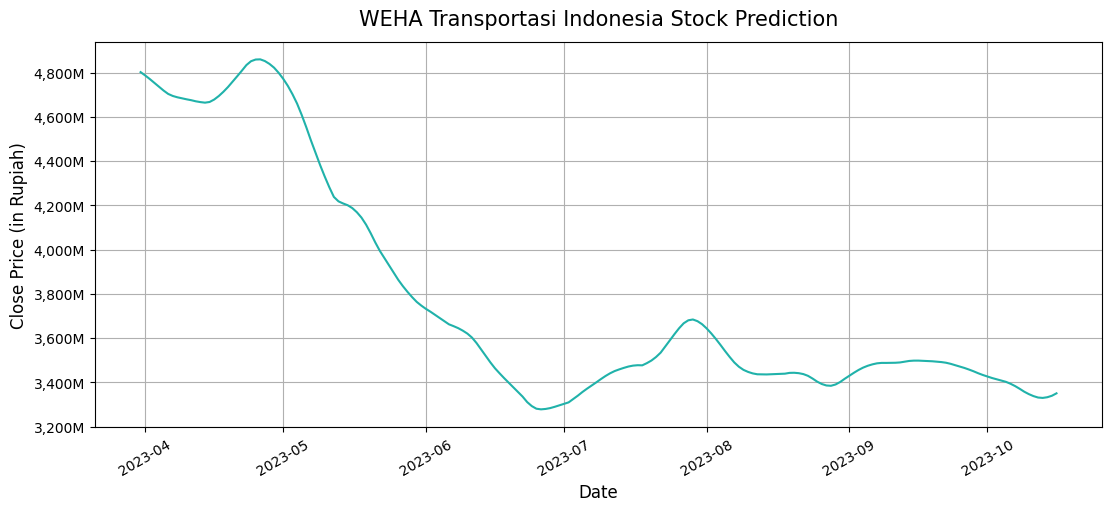

In [57]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaMax

In [58]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_relu_adamax.h5')

Epoch 1/10
24/24 [==============================] - 15s 312ms/step - loss: 0.0408 - val_loss: 0.0090
Epoch 2/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0053 - val_loss: 0.0076
Epoch 3/10
24/24 [==============================] - 6s 243ms/step - loss: 0.0037 - val_loss: 0.0067
Epoch 4/10
24/24 [==============================] - 5s 225ms/step - loss: 0.0029 - val_loss: 0.0065
Epoch 5/10
24/24 [==============================] - 5s 225ms/step - loss: 0.0028 - val_loss: 0.0066
Epoch 6/10
24/24 [==============================] - 6s 239ms/step - loss: 0.0027 - val_loss: 0.0066
Epoch 7/10
24/24 [==============================] - 6s 245ms/step - loss: 0.0025 - val_loss: 0.0068
Epoch 8/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0026 - val_loss: 0.0065
Epoch 9/10
24/24 [==============================] - 6s 257ms/step - loss: 0.0026 - val_loss: 0.0066
Epoch 10/10
24/24 [==============================] - 6s 247ms/step - loss: 0.0023 - val_loss: 0.006

In [59]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 34ms/step
Mean Absolute Error (MAE): 0.0273615
Mean Absolute Percentage Error (MAPE): 0.09051
Root Mean Squared Error (RMSE): 0.03554
Mean Squared Error (MSE): 0.001263
R-Squared (R2): 0.880142
T-Statistic 0.82
P-Value 6.782979490514945e-16
Elapsed Time (min): 70.0


7/7 [==============================] - 0s 34ms/step


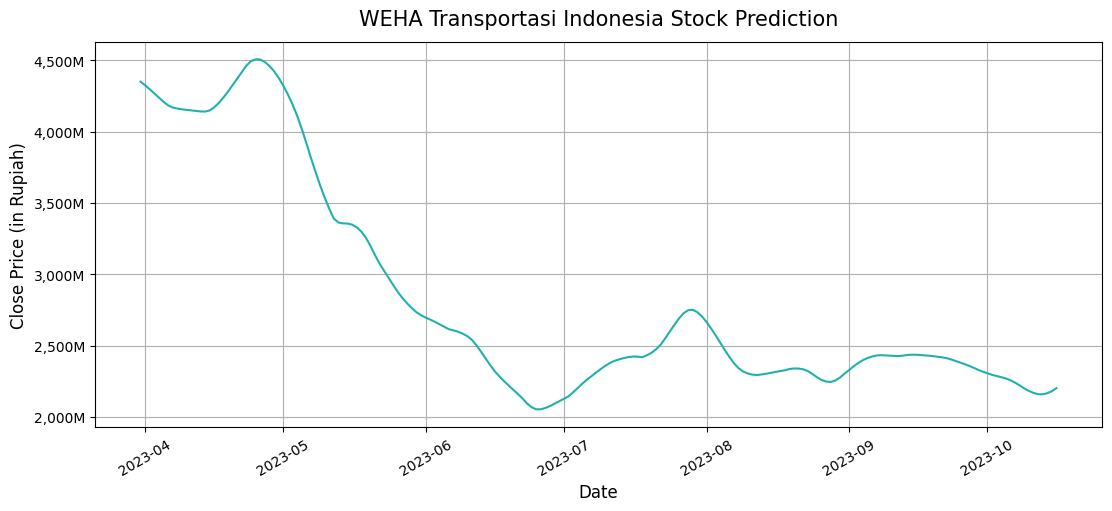

In [60]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Adam

In [61]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_sigmoid_adam.h5')

Epoch 1/10
24/24 [==============================] - 19s 438ms/step - loss: 0.0290 - val_loss: 0.0407
Epoch 2/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0056 - val_loss: 0.0102
Epoch 3/10
24/24 [==============================] - 6s 257ms/step - loss: 0.0020 - val_loss: 0.0082
Epoch 4/10
24/24 [==============================] - 6s 241ms/step - loss: 0.0017 - val_loss: 0.0071
Epoch 5/10
24/24 [==============================] - 6s 234ms/step - loss: 0.0014 - val_loss: 0.0069
Epoch 6/10
24/24 [==============================] - 6s 239ms/step - loss: 0.0014 - val_loss: 0.0067
Epoch 7/10
24/24 [==============================] - 6s 239ms/step - loss: 0.0012 - val_loss: 0.0067
Epoch 8/10
24/24 [==============================] - 6s 246ms/step - loss: 0.0012 - val_loss: 0.0064
Epoch 9/10
24/24 [==============================] - 6s 238ms/step - loss: 0.0011 - val_loss: 0.0061
Epoch 10/10
24/24 [==============================] - 6s 243ms/step - loss: 0.0010 - val_loss: 0.006

In [62]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 46ms/step
Mean Absolute Error (MAE): 0.0271899
Mean Absolute Percentage Error (MAPE): 0.08793
Root Mean Squared Error (RMSE): 0.03573
Mean Squared Error (MSE): 0.0012765
R-Squared (R2): 0.878858
T-Statistic 0.8279
P-Value 1.5583625342707524e-15
Elapsed Time (min): 73.09


7/7 [==============================] - 0s 46ms/step


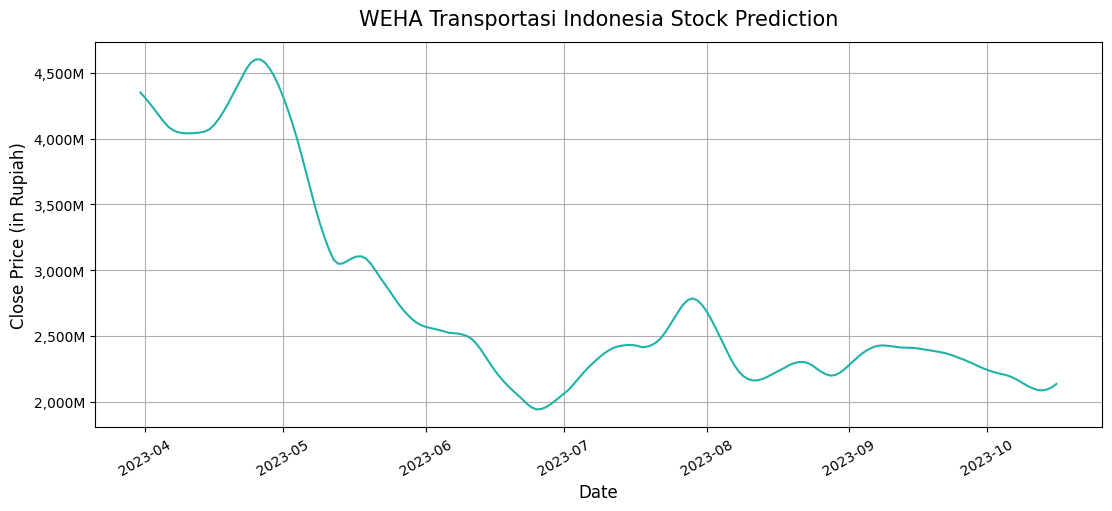

In [63]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaGrad

In [64]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_sigmoid_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 15s 285ms/step - loss: 0.3199 - val_loss: 0.1607
Epoch 2/10
24/24 [==============================] - 6s 232ms/step - loss: 0.2223 - val_loss: 0.1221
Epoch 3/10
24/24 [==============================] - 6s 234ms/step - loss: 0.1719 - val_loss: 0.1003
Epoch 4/10
24/24 [==============================] - 6s 243ms/step - loss: 0.1382 - val_loss: 0.0867
Epoch 5/10
24/24 [==============================] - 6s 240ms/step - loss: 0.1143 - val_loss: 0.0781
Epoch 6/10
24/24 [==============================] - 6s 240ms/step - loss: 0.0963 - val_loss: 0.0726
Epoch 7/10
24/24 [==============================] - 6s 270ms/step - loss: 0.0827 - val_loss: 0.0694
Epoch 8/10
24/24 [==============================] - 7s 285ms/step - loss: 0.0726 - val_loss: 0.0676
Epoch 9/10
24/24 [==============================] - 6s 271ms/step - loss: 0.0639 - val_loss: 0.0669
Epoch 10/10
24/24 [==============================] - 6s 263ms/step - loss: 0.0575 - val_loss: 0.066

In [65]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 34ms/step
Mean Absolute Error (MAE): 0.0954021
Mean Absolute Percentage Error (MAPE): 0.34475
Root Mean Squared Error (RMSE): 0.10197
Mean Squared Error (MSE): 0.0103983
R-Squared (R2): 0.013213
T-Statistic 0.8191
P-Value 6.161544239641171e-16
Elapsed Time (min): 71.42


7/7 [==============================] - 0s 33ms/step


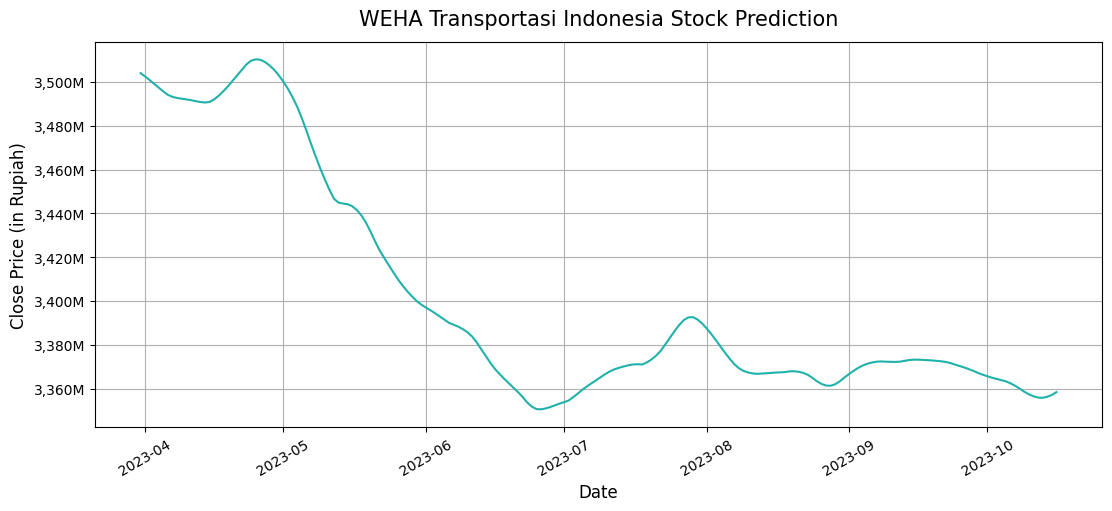

In [66]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Nadam

In [67]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_sigmoid_nadam.h5')

Epoch 1/10
24/24 [==============================] - 17s 315ms/step - loss: 1.2012 - val_loss: 0.1448
Epoch 2/10
24/24 [==============================] - 6s 233ms/step - loss: 0.0547 - val_loss: 0.1096
Epoch 3/10
24/24 [==============================] - 6s 255ms/step - loss: 0.0542 - val_loss: 0.1167
Epoch 4/10
24/24 [==============================] - 6s 241ms/step - loss: 0.0508 - val_loss: 0.1113
Epoch 5/10
24/24 [==============================] - 6s 247ms/step - loss: 0.0463 - val_loss: 0.0926
Epoch 6/10
24/24 [==============================] - 6s 236ms/step - loss: 0.0461 - val_loss: 0.1125
Epoch 7/10
24/24 [==============================] - 6s 236ms/step - loss: 0.0365 - val_loss: 0.0951
Epoch 8/10
24/24 [==============================] - 6s 261ms/step - loss: 0.0253 - val_loss: 0.0477
Epoch 9/10
24/24 [==============================] - 7s 297ms/step - loss: 0.0242 - val_loss: 0.0301
Epoch 10/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0154 - val_loss: 0.018

In [68]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 35ms/step
Mean Absolute Error (MAE): 0.0558406
Mean Absolute Percentage Error (MAPE): 0.19467
Root Mean Squared Error (RMSE): 0.07356
Mean Squared Error (MSE): 0.0054107
R-Squared (R2): 0.486529
T-Statistic 0.8036
P-Value 1.288044886406988e-16
Elapsed Time (min): 72.24


7/7 [==============================] - 0s 35ms/step


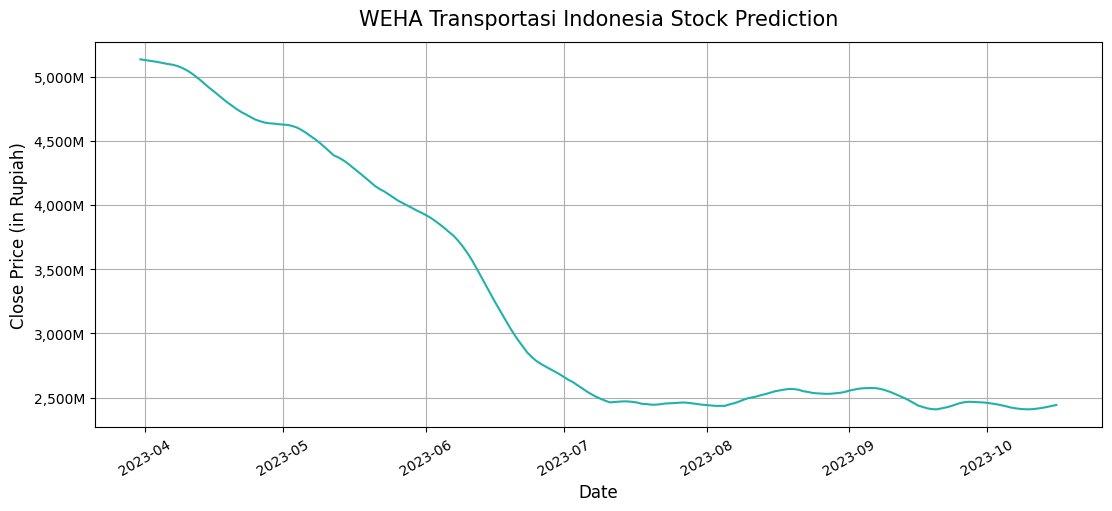

In [69]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - RMSProp

In [70]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_sigmoid_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 16s 308ms/step - loss: 0.0753 - val_loss: 0.0920
Epoch 2/10
24/24 [==============================] - 5s 230ms/step - loss: 0.0337 - val_loss: 0.0468
Epoch 3/10
24/24 [==============================] - 6s 239ms/step - loss: 0.0193 - val_loss: 0.0156
Epoch 4/10
24/24 [==============================] - 6s 244ms/step - loss: 0.0126 - val_loss: 0.0217
Epoch 5/10
24/24 [==============================] - 6s 236ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch 6/10
24/24 [==============================] - 6s 235ms/step - loss: 0.0083 - val_loss: 0.0158
Epoch 7/10
24/24 [==============================] - 6s 260ms/step - loss: 0.0069 - val_loss: 0.0102
Epoch 8/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0066 - val_loss: 0.0112
Epoch 9/10
24/24 [==============================] - 6s 233ms/step - loss: 0.0057 - val_loss: 0.0107
Epoch 10/10
24/24 [==============================] - 6s 231ms/step - loss: 0.0050 - val_loss: 0.008

In [71]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 33ms/step
Mean Absolute Error (MAE): 0.0561839
Mean Absolute Percentage Error (MAPE): 0.1949
Root Mean Squared Error (RMSE): 0.06764
Mean Squared Error (MSE): 0.0045751
R-Squared (R2): 0.565823
T-Statistic 0.8143
P-Value 3.7531823428557155e-16
Elapsed Time (min): 68.78


7/7 [==============================] - 0s 34ms/step


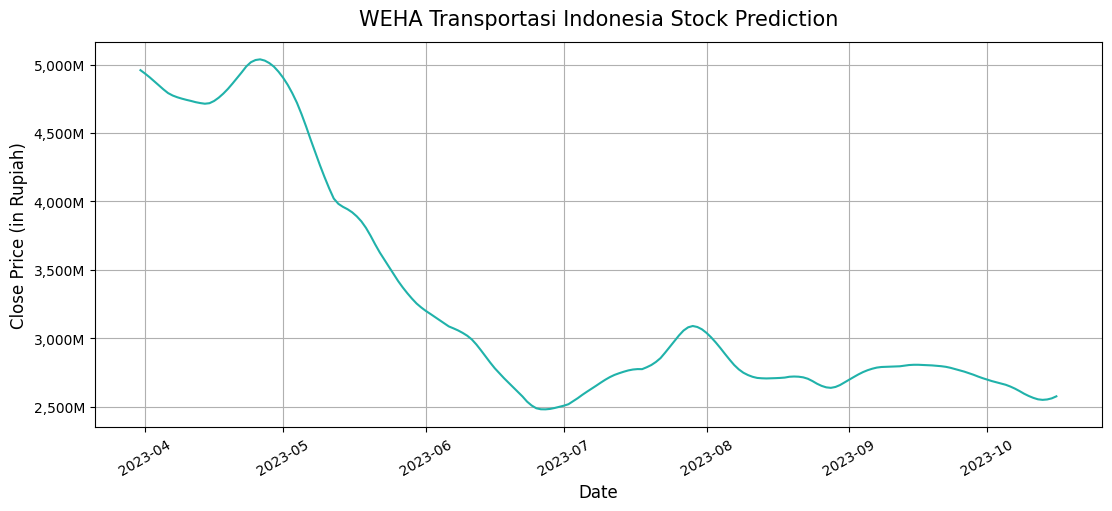

In [72]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaDelta

In [73]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_sigmoid_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 14s 271ms/step - loss: 0.5037 - val_loss: 0.3364
Epoch 2/10
24/24 [==============================] - 5s 204ms/step - loss: 0.5001 - val_loss: 0.3345
Epoch 3/10
24/24 [==============================] - 5s 229ms/step - loss: 0.4970 - val_loss: 0.3325
Epoch 4/10
24/24 [==============================] - 5s 217ms/step - loss: 0.4939 - val_loss: 0.3305
Epoch 5/10
24/24 [==============================] - 5s 218ms/step - loss: 0.4918 - val_loss: 0.3284
Epoch 6/10
24/24 [==============================] - 5s 215ms/step - loss: 0.4885 - val_loss: 0.3263
Epoch 7/10
24/24 [==============================] - 6s 239ms/step - loss: 0.4852 - val_loss: 0.3242
Epoch 8/10
24/24 [==============================] - 5s 226ms/step - loss: 0.4817 - val_loss: 0.3220
Epoch 9/10
24/24 [==============================] - 5s 227ms/step - loss: 0.4780 - val_loss: 0.3198
Epoch 10/10
24/24 [==============================] - 5s 221ms/step - loss: 0.4748 - val_loss: 0.317

In [74]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 33ms/step
Mean Absolute Error (MAE): 0.4872805
Mean Absolute Percentage Error (MAPE): 1.64241
Root Mean Squared Error (RMSE): 0.49706
Mean Squared Error (MSE): 0.2470682
R-Squared (R2): -22.446559
T-Statistic 0.82
P-Value 6.738917365994369e-16
Elapsed Time (min): 62.75


7/7 [==============================] - 0s 32ms/step


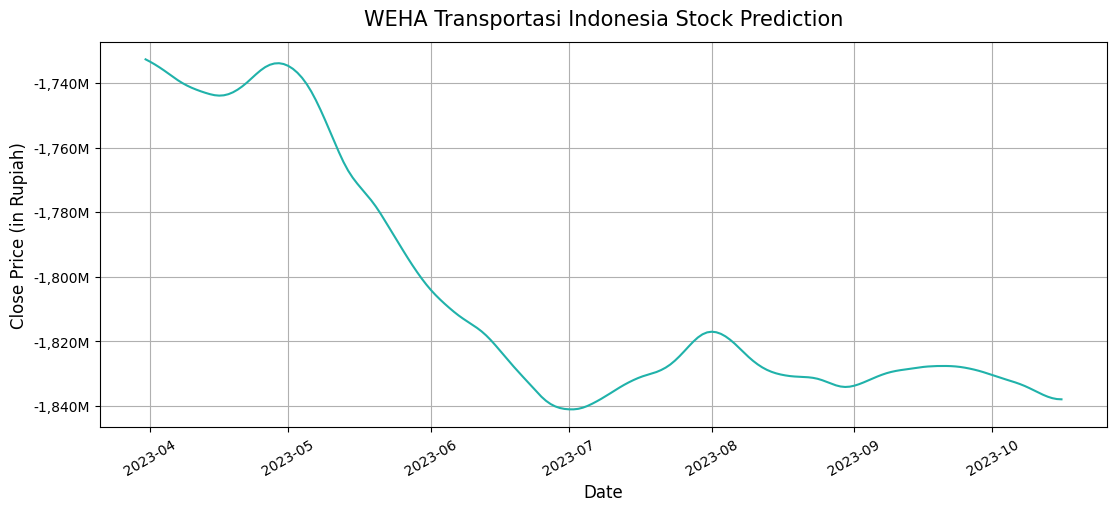

In [75]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - SGD

In [76]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_sigmoid_sgd.h5')

Epoch 1/10
24/24 [==============================] - 14s 292ms/step - loss: 0.0479 - val_loss: 0.1088
Epoch 2/10
24/24 [==============================] - 5s 226ms/step - loss: 0.0435 - val_loss: 0.1081
Epoch 3/10
24/24 [==============================] - 6s 257ms/step - loss: 0.0432 - val_loss: 0.1094
Epoch 4/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0426 - val_loss: 0.1078
Epoch 5/10
24/24 [==============================] - 6s 248ms/step - loss: 0.0421 - val_loss: 0.1021
Epoch 6/10
24/24 [==============================] - 6s 272ms/step - loss: 0.0416 - val_loss: 0.0996
Epoch 7/10
24/24 [==============================] - 6s 264ms/step - loss: 0.0411 - val_loss: 0.1027
Epoch 8/10
24/24 [==============================] - 6s 245ms/step - loss: 0.0405 - val_loss: 0.1014
Epoch 9/10
24/24 [==============================] - 6s 269ms/step - loss: 0.0402 - val_loss: 0.1000
Epoch 10/10
24/24 [==============================] - 6s 249ms/step - loss: 0.0398 - val_loss: 0.095

In [77]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 45ms/step
Mean Absolute Error (MAE): 0.1710757
Mean Absolute Percentage Error (MAPE): 0.6951
Root Mean Squared Error (RMSE): 0.19296
Mean Squared Error (MSE): 0.037233
R-Squared (R2): -2.533382
T-Statistic 0.8207
P-Value 7.243731532503394e-16
Elapsed Time (min): 69.89


7/7 [==============================] - 0s 41ms/step


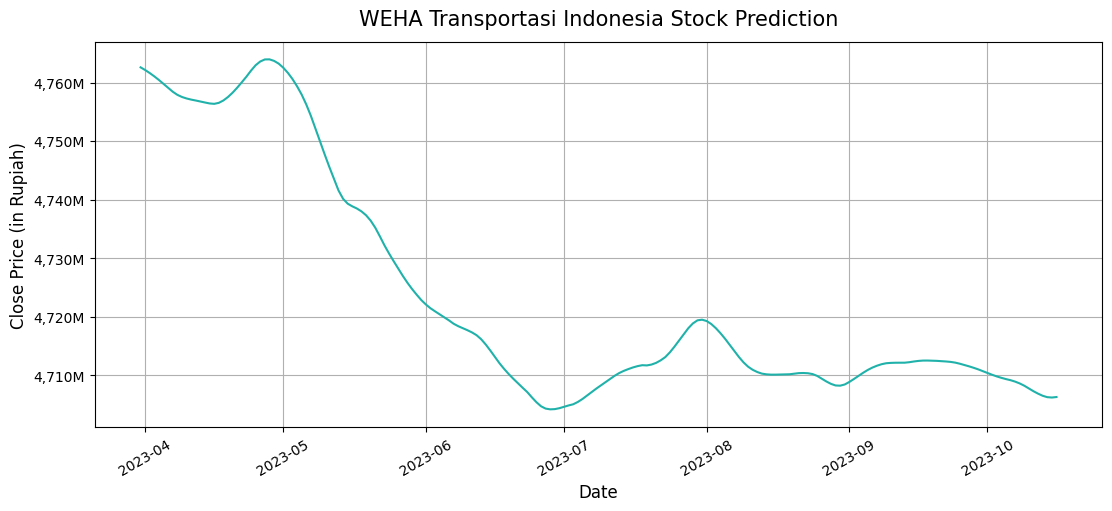

In [78]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaMax

In [79]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_sigmoid_adamax.h5')

Epoch 1/10
24/24 [==============================] - 15s 327ms/step - loss: 0.1109 - val_loss: 0.0211
Epoch 2/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0136 - val_loss: 0.0125
Epoch 3/10
24/24 [==============================] - 6s 240ms/step - loss: 0.0073 - val_loss: 0.0088
Epoch 4/10
24/24 [==============================] - 6s 235ms/step - loss: 0.0039 - val_loss: 0.0083
Epoch 5/10
24/24 [==============================] - 6s 268ms/step - loss: 0.0031 - val_loss: 0.0083
Epoch 6/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0028 - val_loss: 0.0081
Epoch 7/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0028 - val_loss: 0.0080
Epoch 8/10
24/24 [==============================] - 6s 243ms/step - loss: 0.0027 - val_loss: 0.0079
Epoch 9/10
24/24 [==============================] - 6s 239ms/step - loss: 0.0026 - val_loss: 0.0078
Epoch 10/10
24/24 [==============================] - 6s 245ms/step - loss: 0.0024 - val_loss: 0.007

In [80]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 38ms/step
Mean Absolute Error (MAE): 0.0310937
Mean Absolute Percentage Error (MAPE): 0.10239
Root Mean Squared Error (RMSE): 0.04193
Mean Squared Error (MSE): 0.0017582
R-Squared (R2): 0.83315
T-Statistic 0.8166
P-Value 4.765397302736445e-16
Elapsed Time (min): 70.2


7/7 [==============================] - 0s 39ms/step


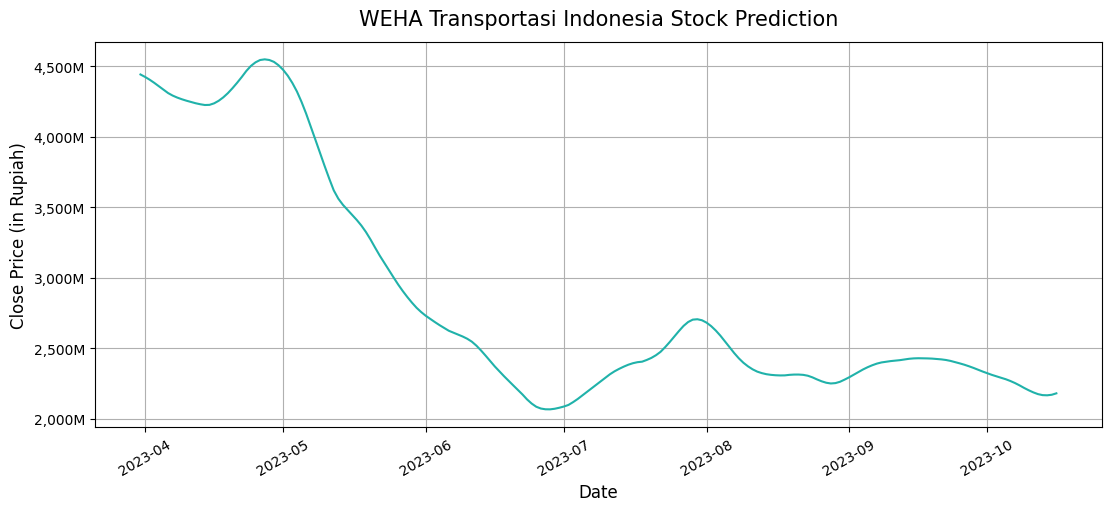

In [81]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Adam

In [82]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_tanh_adam.h5')

Epoch 1/10
24/24 [==============================] - 17s 364ms/step - loss: 0.0350 - val_loss: 0.0085
Epoch 2/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0044 - val_loss: 0.0058
Epoch 3/10
24/24 [==============================] - 7s 278ms/step - loss: 0.0026 - val_loss: 0.0059
Epoch 4/10
24/24 [==============================] - 7s 295ms/step - loss: 0.0022 - val_loss: 0.0054
Epoch 5/10
24/24 [==============================] - 7s 283ms/step - loss: 0.0021 - val_loss: 0.0052
Epoch 6/10
24/24 [==============================] - 7s 278ms/step - loss: 0.0019 - val_loss: 0.0051
Epoch 7/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0018 - val_loss: 0.0051
Epoch 8/10
24/24 [==============================] - 6s 261ms/step - loss: 0.0018 - val_loss: 0.0053
Epoch 9/10
24/24 [==============================] - 6s 268ms/step - loss: 0.0018 - val_loss: 0.0050
Epoch 10/10
24/24 [==============================] - 7s 280ms/step - loss: 0.0017 - val_loss: 0.004

In [83]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 38ms/step
Mean Absolute Error (MAE): 0.0256809
Mean Absolute Percentage Error (MAPE): 0.08505
Root Mean Squared Error (RMSE): 0.03394
Mean Squared Error (MSE): 0.0011522
R-Squared (R2): 0.890653
T-Statistic 0.8269
P-Value 1.3966355690361735e-15
Elapsed Time (min): 77.36


7/7 [==============================] - 0s 42ms/step


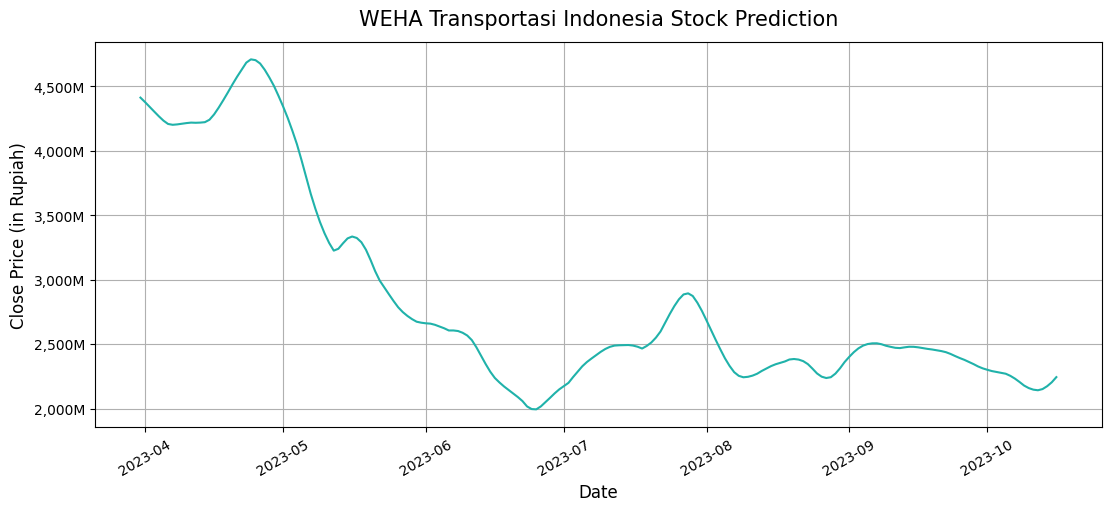

In [84]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaGrad

In [85]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_tanh_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 15s 358ms/step - loss: 0.1678 - val_loss: 0.0708
Epoch 2/10
24/24 [==============================] - 6s 262ms/step - loss: 0.0732 - val_loss: 0.0473
Epoch 3/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0396 - val_loss: 0.0416
Epoch 4/10
24/24 [==============================] - 6s 262ms/step - loss: 0.0260 - val_loss: 0.0410
Epoch 5/10
24/24 [==============================] - 6s 251ms/step - loss: 0.0222 - val_loss: 0.0413
Epoch 6/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0206 - val_loss: 0.0412
Epoch 7/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0191 - val_loss: 0.0405
Epoch 8/10
24/24 [==============================] - 6s 261ms/step - loss: 0.0181 - val_loss: 0.0397
Epoch 9/10
24/24 [==============================] - 6s 260ms/step - loss: 0.0184 - val_loss: 0.0385
Epoch 10/10
24/24 [==============================] - 6s 236ms/step - loss: 0.0176 - val_loss: 0.037

In [86]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 46ms/step
Mean Absolute Error (MAE): 0.1212396
Mean Absolute Percentage Error (MAPE): 0.48275
Root Mean Squared Error (RMSE): 0.13292
Mean Squared Error (MSE): 0.0176672
R-Squared (R2): -0.676603
T-Statistic 0.819
P-Value 6.090547526189092e-16
Elapsed Time (min): 71.78


7/7 [==============================] - 0s 37ms/step


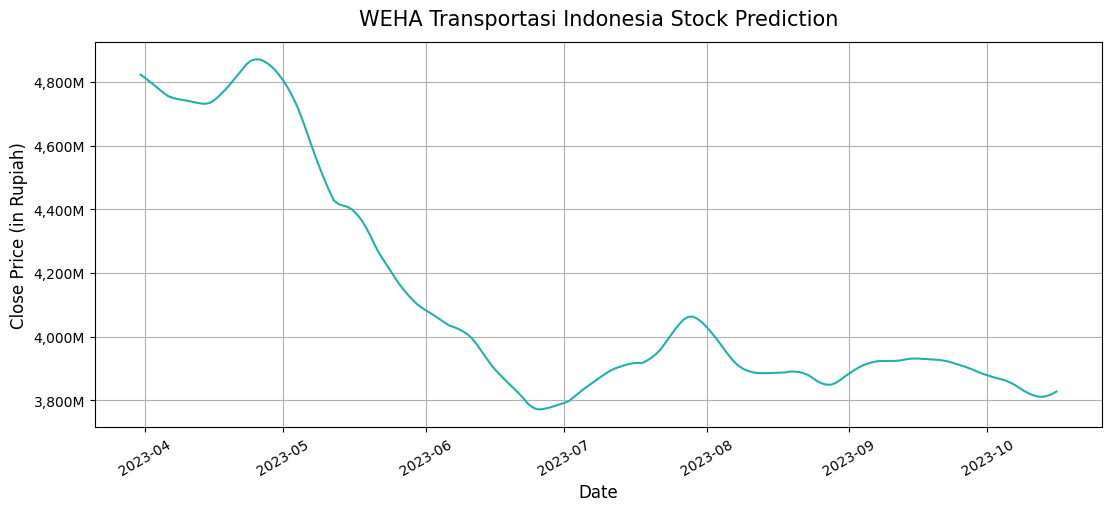

In [87]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Nadam

In [88]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_tanh_nadam.h5')

Epoch 1/10
24/24 [==============================] - 18s 311ms/step - loss: 0.0211 - val_loss: 0.0077
Epoch 2/10
24/24 [==============================] - 6s 240ms/step - loss: 0.0033 - val_loss: 0.0078
Epoch 3/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0027 - val_loss: 0.0062
Epoch 4/10
24/24 [==============================] - 6s 246ms/step - loss: 0.0023 - val_loss: 0.0060
Epoch 5/10
24/24 [==============================] - 6s 252ms/step - loss: 0.0021 - val_loss: 0.0061
Epoch 6/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0020 - val_loss: 0.0057
Epoch 7/10
24/24 [==============================] - 6s 240ms/step - loss: 0.0019 - val_loss: 0.0055
Epoch 8/10
24/24 [==============================] - 5s 229ms/step - loss: 0.0018 - val_loss: 0.0052
Epoch 9/10
24/24 [==============================] - 6s 230ms/step - loss: 0.0017 - val_loss: 0.0051
Epoch 10/10
24/24 [==============================] - 6s 270ms/step - loss: 0.0016 - val_loss: 0.005

In [89]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Error (MAE): 0.0255236
Mean Absolute Percentage Error (MAPE): 0.08348
Root Mean Squared Error (RMSE): 0.03389
Mean Squared Error (MSE): 0.0011487
R-Squared (R2): 0.890993
T-Statistic 0.8275
P-Value 1.504252057896898e-15
Elapsed Time (min): 71.77


7/7 [==============================] - 0s 41ms/step


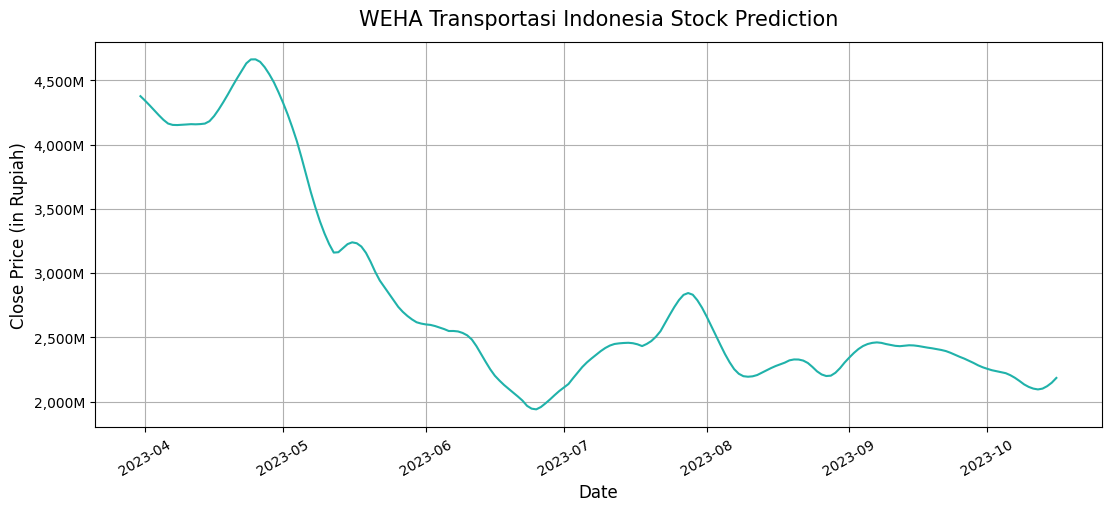

In [90]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - RMSProp

In [91]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_tanh_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 14s 299ms/step - loss: 0.0234 - val_loss: 0.0069
Epoch 2/10
24/24 [==============================] - 6s 234ms/step - loss: 0.0071 - val_loss: 0.0076
Epoch 3/10
24/24 [==============================] - 6s 238ms/step - loss: 0.0061 - val_loss: 0.0074
Epoch 4/10
24/24 [==============================] - 6s 238ms/step - loss: 0.0058 - val_loss: 0.0048
Epoch 5/10
24/24 [==============================] - 6s 243ms/step - loss: 0.0043 - val_loss: 0.0057
Epoch 6/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0038 - val_loss: 0.0045
Epoch 7/10
24/24 [==============================] - 6s 246ms/step - loss: 0.0039 - val_loss: 0.0074
Epoch 8/10
24/24 [==============================] - 6s 244ms/step - loss: 0.0036 - val_loss: 0.0054
Epoch 9/10
24/24 [==============================] - 6s 260ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 10/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0033 - val_loss: 0.004

In [92]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 36ms/step
Mean Absolute Error (MAE): 0.0345188
Mean Absolute Percentage Error (MAPE): 0.11929
Root Mean Squared Error (RMSE): 0.04267
Mean Squared Error (MSE): 0.001821
R-Squared (R2): 0.827186
T-Statistic 0.829
P-Value 1.76428174946243e-15
Elapsed Time (min): 68.89


7/7 [==============================] - 0s 37ms/step


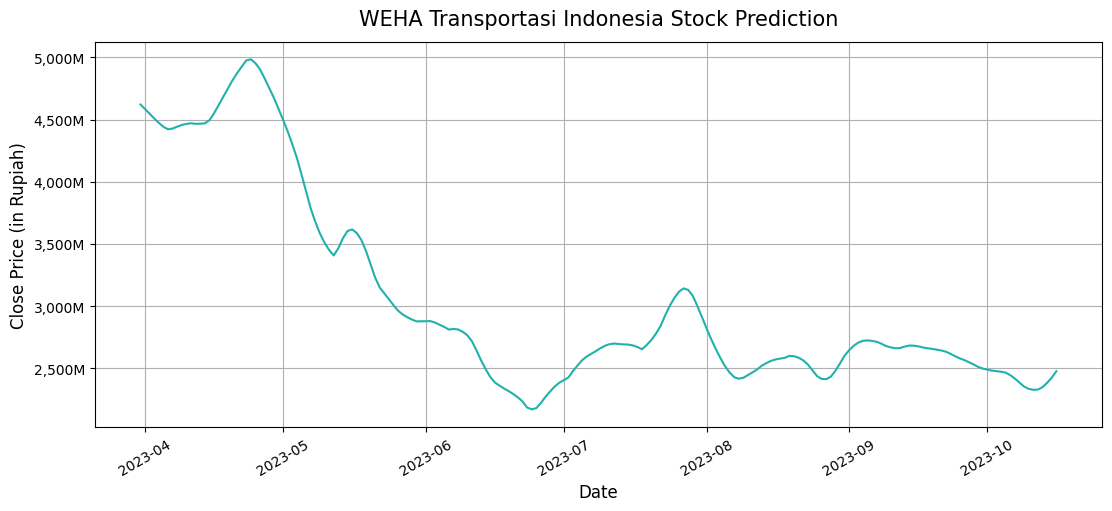

In [93]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaDelta

In [94]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_tanh_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 14s 288ms/step - loss: 0.2940 - val_loss: 0.1825
Epoch 2/10
24/24 [==============================] - 6s 233ms/step - loss: 0.2884 - val_loss: 0.1795
Epoch 3/10
24/24 [==============================] - 5s 227ms/step - loss: 0.2831 - val_loss: 0.1764
Epoch 4/10
24/24 [==============================] - 6s 231ms/step - loss: 0.2783 - val_loss: 0.1733
Epoch 5/10
24/24 [==============================] - 6s 238ms/step - loss: 0.2722 - val_loss: 0.1702
Epoch 6/10
24/24 [==============================] - 6s 239ms/step - loss: 0.2682 - val_loss: 0.1671
Epoch 7/10
24/24 [==============================] - 6s 232ms/step - loss: 0.2626 - val_loss: 0.1639
Epoch 8/10
24/24 [==============================] - 6s 234ms/step - loss: 0.2576 - val_loss: 0.1608
Epoch 9/10
24/24 [==============================] - 6s 254ms/step - loss: 0.2503 - val_loss: 0.1576
Epoch 10/10
24/24 [==============================] - 6s 244ms/step - loss: 0.2468 - val_loss: 0.154

In [95]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 37ms/step
Mean Absolute Error (MAE): 0.2811222
Mean Absolute Percentage Error (MAPE): 0.90771
Root Mean Squared Error (RMSE): 0.29773
Mean Squared Error (MSE): 0.0886422
R-Squared (R2): -7.412066
T-Statistic 0.8065
P-Value 1.701824451607654e-16
Elapsed Time (min): 65.84


7/7 [==============================] - 0s 35ms/step


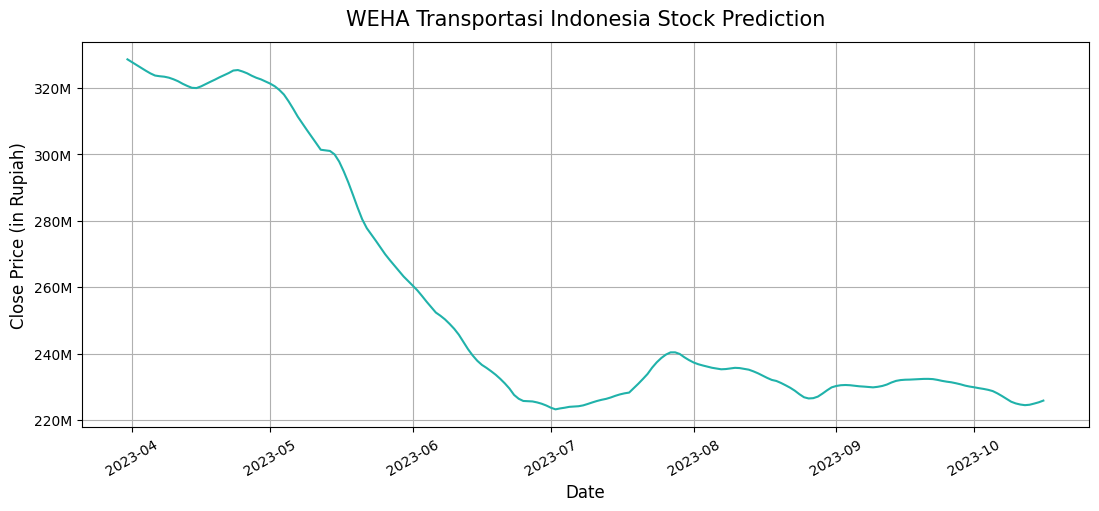

In [96]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - SGD

In [97]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_tanh_sgd.h5')

Epoch 1/10
24/24 [==============================] - 13s 283ms/step - loss: 0.0615 - val_loss: 0.0642
Epoch 2/10
24/24 [==============================] - 5s 229ms/step - loss: 0.0251 - val_loss: 0.0471
Epoch 3/10
24/24 [==============================] - 6s 237ms/step - loss: 0.0202 - val_loss: 0.0370
Epoch 4/10
24/24 [==============================] - 6s 239ms/step - loss: 0.0150 - val_loss: 0.0268
Epoch 5/10
24/24 [==============================] - 6s 269ms/step - loss: 0.0114 - val_loss: 0.0197
Epoch 6/10
24/24 [==============================] - 7s 277ms/step - loss: 0.0088 - val_loss: 0.0149
Epoch 7/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0071 - val_loss: 0.0118
Epoch 8/10
24/24 [==============================] - 7s 292ms/step - loss: 0.0054 - val_loss: 0.0103
Epoch 9/10
24/24 [==============================] - 7s 281ms/step - loss: 0.0048 - val_loss: 0.0097
Epoch 10/10
24/24 [==============================] - 7s 274ms/step - loss: 0.0042 - val_loss: 0.009

In [98]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Error (MAE): 0.0397785
Mean Absolute Percentage Error (MAPE): 0.13997
Root Mean Squared Error (RMSE): 0.04972
Mean Squared Error (MSE): 0.0024724
R-Squared (R2): 0.765371
T-Statistic 0.8152
P-Value 4.0966923194499607e-16
Elapsed Time (min): 71.24


7/7 [==============================] - 0s 56ms/step


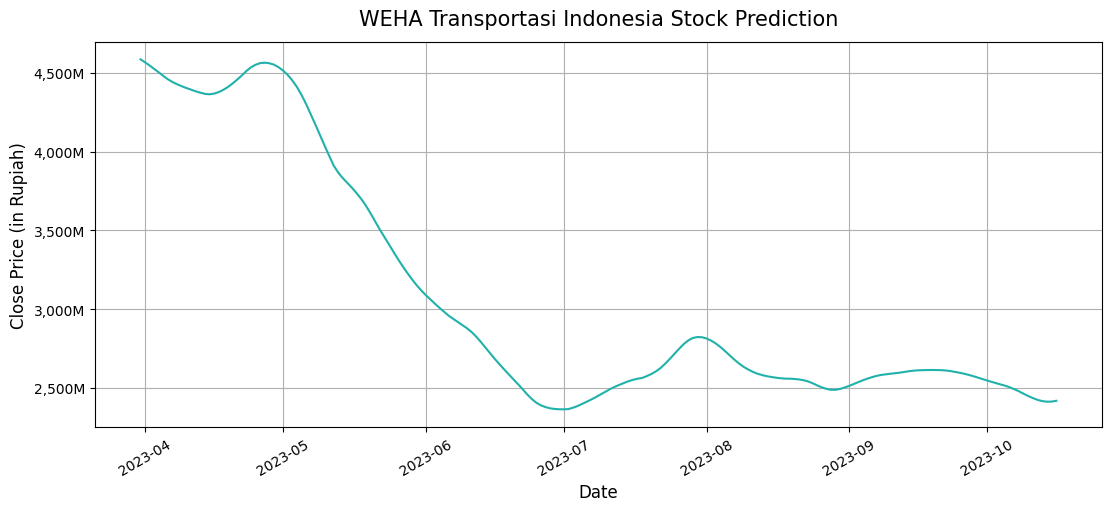

In [99]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaMax

In [100]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/weha_tanh_adamax.h5')

Epoch 1/10
24/24 [==============================] - 16s 326ms/step - loss: 0.0315 - val_loss: 0.0087
Epoch 2/10
24/24 [==============================] - 6s 259ms/step - loss: 0.0055 - val_loss: 0.0069
Epoch 3/10
24/24 [==============================] - 6s 262ms/step - loss: 0.0040 - val_loss: 0.0060
Epoch 4/10
24/24 [==============================] - 6s 265ms/step - loss: 0.0032 - val_loss: 0.0058
Epoch 5/10
24/24 [==============================] - 6s 240ms/step - loss: 0.0032 - val_loss: 0.0057
Epoch 6/10
24/24 [==============================] - 7s 288ms/step - loss: 0.0028 - val_loss: 0.0057
Epoch 7/10
24/24 [==============================] - 6s 268ms/step - loss: 0.0026 - val_loss: 0.0057
Epoch 8/10
24/24 [==============================] - 6s 238ms/step - loss: 0.0025 - val_loss: 0.0058
Epoch 9/10
24/24 [==============================] - 6s 238ms/step - loss: 0.0026 - val_loss: 0.0056
Epoch 10/10
24/24 [==============================] - 6s 248ms/step - loss: 0.0023 - val_loss: 0.005

In [101]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 48ms/step
Mean Absolute Error (MAE): 0.0269378
Mean Absolute Percentage Error (MAPE): 0.089
Root Mean Squared Error (RMSE): 0.03531
Mean Squared Error (MSE): 0.0012465
R-Squared (R2): 0.881711
T-Statistic 0.8223
P-Value 8.573300620962749e-16
Elapsed Time (min): 72.91


7/7 [==============================] - 0s 42ms/step


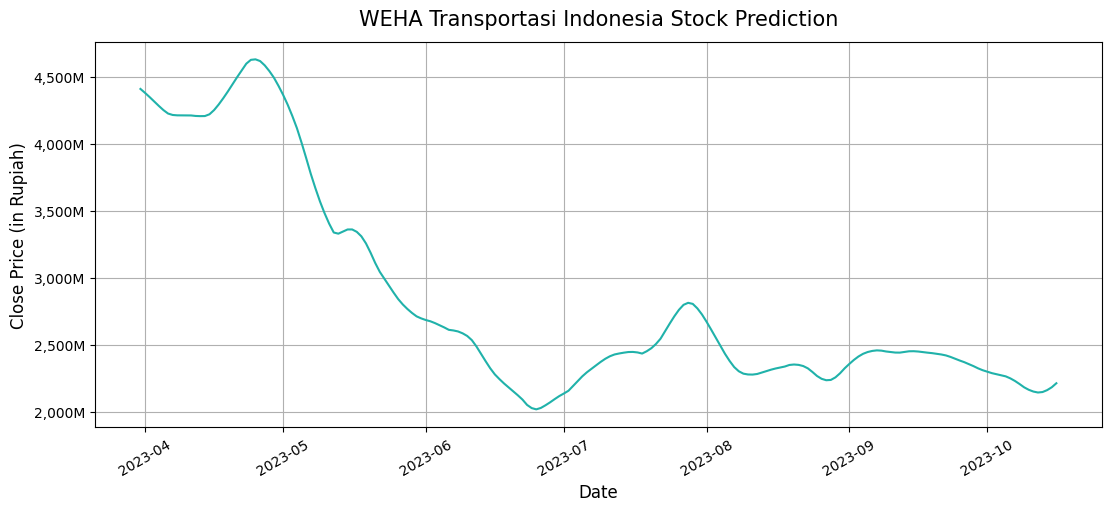

In [102]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_weha.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='lightseagreen')
plt.title('WEHA Transportasi Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Comparison LSTM Model based on Activation and Optimizer Parameter

In [103]:
# Define the activation functions and optimizers to be tested
activations = ['linear', 'relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'adagrad', 'nadam', 'rmsprop', 'adadelta', 'sgd', 'adamax']

# Generate all possible combinations of activation functions and optimizers
combinations = list(itertools.product(activations, optimizers))

# Define a function to build and train an LSTM model with a given activation function and optimizer
def build_model(activations, optimizers):
    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activations))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers)
    model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.1, verbose=0)
    return model

# Train and evaluate the models for all possible combinations of activation functions and optimizers
import time
results = []
for activations, optimizers in combinations:
    print(f'Training model with {activations} activation and {optimizers} optimizer')
    start_time = time.time()
    model = build_model(activations, optimizers)
    end_time = time.time()
    preds = model.predict(X_test)
    stat, p = stats.shapiro(preds)
    mape = round(metrics.mean_absolute_percentage_error(y_test, preds), 5)
    mae = round(metrics.mean_absolute_error(y_test, preds), 5)
    mse = round(metrics.mean_squared_error(y_test, preds), 5)
    rmse = round(math.sqrt(mse), 5)
    r2 = round(metrics.r2_score(y_test, preds), 2)
    elapsed_time = round(end_time - start_time, 2)
    results.append([activations, optimizers, mape, mae, mse, rmse, r2, elapsed_time, stat, p])

# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])

Training model with linear activation and adam optimizer
8/8 [==============================] - 2s 74ms/step
Training model with linear activation and adagrad optimizer
8/8 [==============================] - 3s 55ms/step
Training model with linear activation and nadam optimizer
8/8 [==============================] - 3s 52ms/step
Training model with linear activation and rmsprop optimizer
8/8 [==============================] - 2s 42ms/step
Training model with linear activation and adadelta optimizer
8/8 [==============================] - 3s 46ms/step
Training model with linear activation and sgd optimizer
8/8 [==============================] - 2s 47ms/step
Training model with linear activation and adamax optimizer
8/8 [==============================] - 2s 42ms/step
Training model with relu activation and adam optimizer
8/8 [==============================] - 2s 44ms/step
Training model with relu activation and adagrad optimizer
8/8 [==============================] - 2s 42ms/step
Training

In [104]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get several LSTM model evaluation 
df_pivot_result.sort_values(by=['Activation', 'Optimizer'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adadelta                75.70  0.26324   0.84969  0.07782   
           adagrad                 71.46  0.11103   0.44075  0.01477   
           adam                    70.23  0.02471   0.08098  0.00108   
           adamax                  77.47  0.02731   0.09034  0.00126   
           nadam                   86.13  0.02679   0.08835  0.00124   
           rmsprop                 78.34  0.03359   0.11493  0.00177   
           sgd                     78.47  0.06940   0.26939  0.00585   
relu       adadelta                80.97  0.29308   0.94819  0.09595   
           adagrad                 74.93  0.13230   0.52710  0.02100   
           adam                    73.34  0.02606   0.08472  0.00114   
           adamax                  74.09  0.02741   0.09021  0.00127   
           nadam                   79.52  0.02660   0.08698  0.00120   
           rmsprop                 74.99  0.02588   0.08668  0.00114   
           sgd                     81.47  0.07871   0.30621  0.00743   
sigmoid    adadelta                80.03  0.11494   0.44281  0.01539   
           adagrad                 80.83  0.19224   0.77457  0.04555   
           adam                    79.33  0.02723   0.08788  0.00132   
           adamax                 102.56  0.04611   0.15298  0.00363   
           nadam                   82.26  0.03868   0.12822  0.00231   
           rmsprop                 83.75  0.04146   0.13999  0.00291   
           sgd                     81.35  0.16592   0.67329  0.03485   
tanh       adadelta                86.74  0.25882   0.83506  0.07528   
           adagrad                 81.48  0.12999   0.51789  0.02029   
           adam                    78.06  0.02373   0.07759  0.00097   
           adamax                  77.15  0.02791   0.09226  0.00134   
           nadam                   95.33  0.02770   0.09097  0.00136   
           rmsprop                 87.16  0.03570   0.11608  0.00189   
           sgd                     86.36  0.03582   0.12756  0.00193   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
linear     adadelta   1.389260e-15          -6.38   0.27896     0.826801  
           adagrad    5.103160e-16          -0.40   0.12153     0.817306  
           adam       1.493758e-15           0.90   0.03286     0.827475  
           adamax     6.227396e-16           0.88   0.03550     0.819223  
           nadam      1.706023e-15           0.88   0.03521     0.828704  
           rmsprop    1.770871e-15           0.83   0.04207     0.829048  
           sgd        5.132658e-16           0.44   0.07649     0.817361  
relu       adadelta   7.152990e-14          -8.11   0.30976     0.860789  
           adagrad    7.727730e-16          -0.99   0.14491     0.821284  
           adam       1.233748e-15           0.89   0.03376     0.825695  
           adamax     6.392018e-16           0.88   0.03564     0.819473  
           nadam      5.646985e-15           0.89   0.03464     0.839498  
           rmsprop    1.573954e-15           0.89   0.03376     0.827960  
           sgd        5.428807e-16           0.29   0.08620     0.817903  
sigmoid    adadelta   9.360940e-16          -0.46   0.12406     0.823101  
           adagrad    6.411992e-16          -3.32   0.21342     0.819503  
           adam       1.244409e-15           0.87   0.03633     0.825775  
           adamax     3.784147e-16           0.66   0.06025     0.814399  
           nadam      6.061595e-16           0.78   0.04806     0.818964  
           rmsprop    7.867759e-16           0.72   0.05394     0.821455  
           sgd        5.800619e-16          -2.31   0.18668     0.818541  
tanh       adadelta   6.149671e-16          -6.14   0.27437     0.819102  
           adagrad    6.323717e-16          -0.93   0.14244  

In [105]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get best of LSTM model evaluation 
df_pivot_result.sort_values(by=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'Elapsed Time (min)'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
tanh       adam                    78.06  0.02373   0.07759  0.00097   
linear     adam                    70.23  0.02471   0.08098  0.00108   
relu       adam                    73.34  0.02606   0.08472  0.00114   
           rmsprop                 74.99  0.02588   0.08668  0.00114   
           nadam                   79.52  0.02660   0.08698  0.00120   
sigmoid    adam                    79.33  0.02723   0.08788  0.00132   
linear     nadam                   86.13  0.02679   0.08835  0.00124   
relu       adamax                  74.09  0.02741   0.09021  0.00127   
linear     adamax                  77.47  0.02731   0.09034  0.00126   
tanh       nadam                   95.33  0.02770   0.09097  0.00136   
           adamax                  77.15  0.02791   0.09226  0.00134   
linear     rmsprop                 78.34  0.03359   0.11493  0.00177   
tanh       rmsprop                 87.16  0.03570   0.11608  0.00189   
           sgd                     86.36  0.03582   0.12756  0.00193   
sigmoid    nadam                   82.26  0.03868   0.12822  0.00231   
           rmsprop                 83.75  0.04146   0.13999  0.00291   
           adamax                 102.56  0.04611   0.15298  0.00363   
linear     sgd                     78.47  0.06940   0.26939  0.00585   
relu       sgd                     81.47  0.07871   0.30621  0.00743   
linear     adagrad                 71.46  0.11103   0.44075  0.01477   
sigmoid    adadelta                80.03  0.11494   0.44281  0.01539   
tanh       adagrad                 81.48  0.12999   0.51789  0.02029   
relu       adagrad                 74.93  0.13230   0.52710  0.02100   
sigmoid    sgd                     81.35  0.16592   0.67329  0.03485   
           adagrad                 80.83  0.19224   0.77457  0.04555   
tanh       adadelta                86.74  0.25882   0.83506  0.07528   
linear     adadelta                75.70  0.26324   0.84969  0.07782   
relu       adadelta                80.97  0.29308   0.94819  0.09595   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
tanh       adam       1.479339e-15           0.91   0.03114     0.827385  
linear     adam       1.493758e-15           0.90   0.03286     0.827475  
relu       adam       1.233748e-15           0.89   0.03376     0.825695  
           rmsprop    1.573954e-15           0.89   0.03376     0.827960  
           nadam      5.646985e-15           0.89   0.03464     0.839498  
sigmoid    adam       1.244409e-15           0.87   0.03633     0.825775  
linear     nadam      1.706023e-15           0.88   0.03521     0.828704  
relu       adamax     6.392018e-16           0.88   0.03564     0.819473  
linear     adamax     6.227396e-16           0.88   0.03550     0.819223  
tanh       nadam      1.627001e-15           0.87   0.03688     0.828266  
           adamax     7.165864e-16           0.87   0.03661     0.820565  
linear     rmsprop    1.770871e-15           0.83   0.04207     0.829048  
tanh       rmsprop    1.896852e-15           0.82   0.04347     0.829681  
           sgd        5.757290e-16           0.82   0.04393     0.818469  
sigmoid    nadam      6.061595e-16           0.78   0.04806     0.818964  
           rmsprop    7.867759e-16           0.72   0.05394     0.821455  
           adamax     3.784147e-16           0.66   0.06025     0.814399  
linear     sgd        5.132658e-16           0.44   0.07649     0.817361  
relu       sgd        5.428807e-16           0.29   0.08620     0.817903  
linear     adagrad    5.103160e-16          -0.40   0.12153     0.817306  
sigmoid    adadelta   9.360940e-16          -0.46   0.12406     0.823101  
tanh       adagrad    6.323717e-16          -0.93   0.14244     0.819370  
relu       adagrad    7.727730e-16          -0.99   0.14491  

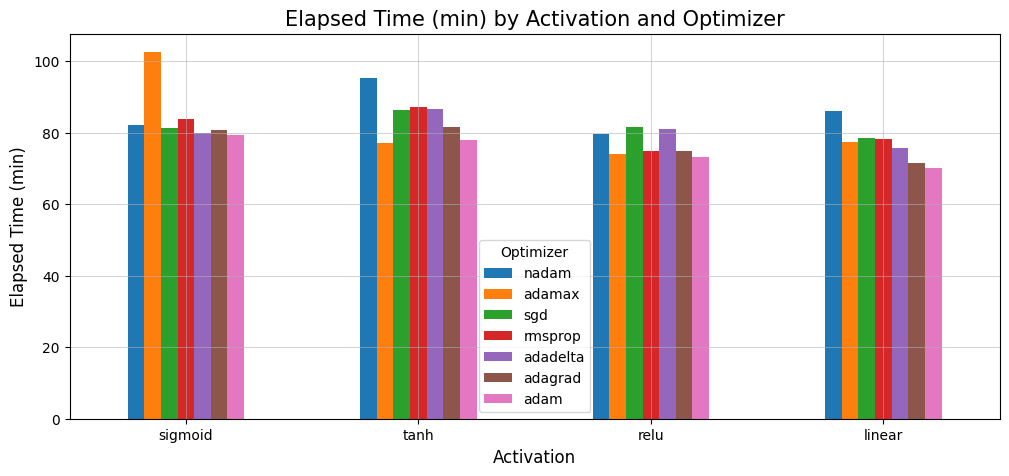

In [106]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_time = df_result.pivot_table(index='Activation', columns='Optimizer', values='Elapsed Time (min)')
# Sort the columns based on the mean elapsed time value
df_time = df_time[df_time.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_time = df_time.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean elapsed time value
df_time = df_time.sort_values(by=df_time.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_time.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Elapsed Time (min)', fontsize=12)
ax.set_title('Elapsed Time (min) by Activation and Optimizer', fontsize=15)
# formatter = ticker.PercentFormatter(xmax=1, decimals=0)
# ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

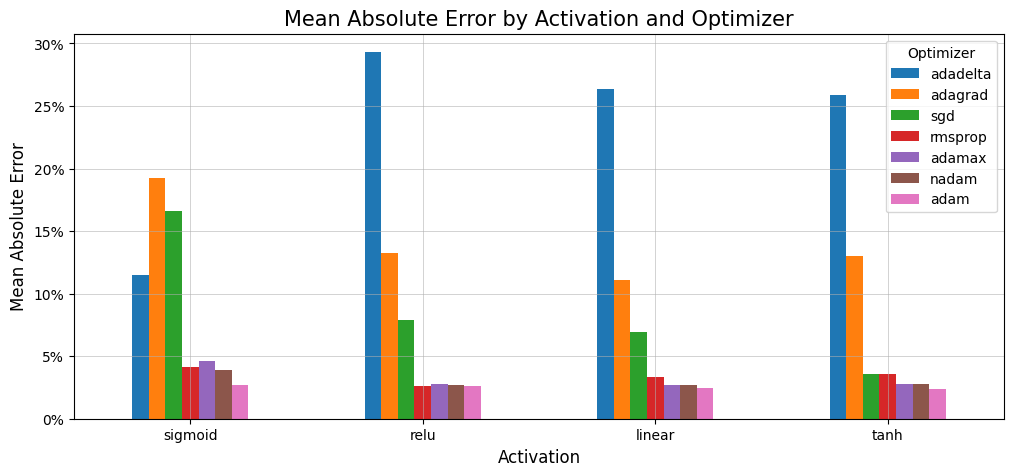

In [107]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mae = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAE (%)')
# Sort the columns based on the mean MAE value
df_mae = df_mae[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mae = df_mae.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAE value
df_mae = df_mae.sort_values(by=df_mae.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mae.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

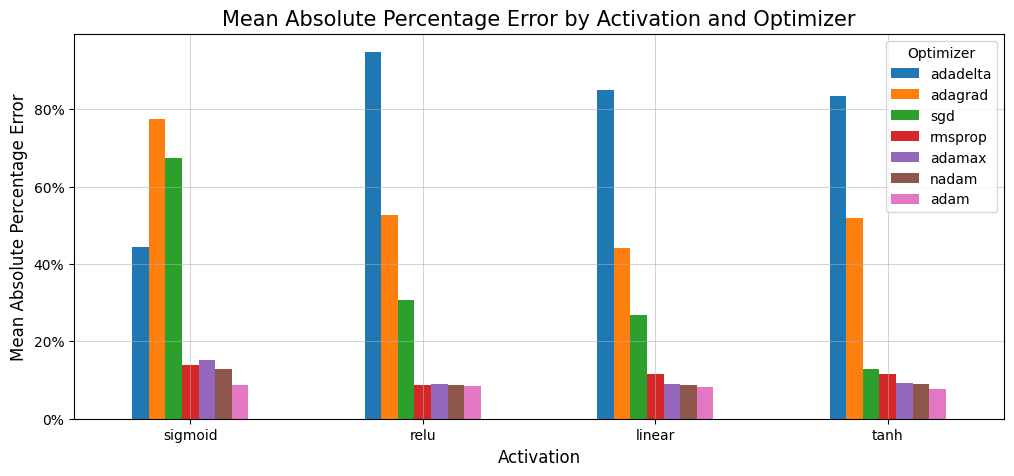

In [108]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mape = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAPE (%)')
# Sort the columns based on the mean MAPE value
df_mape = df_mape[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mape = df_mape.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAPE value
df_mape = df_mape.sort_values(by=df_mape.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mape.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Percentage Error', fontsize=12)
ax.set_title('Mean Absolute Percentage Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

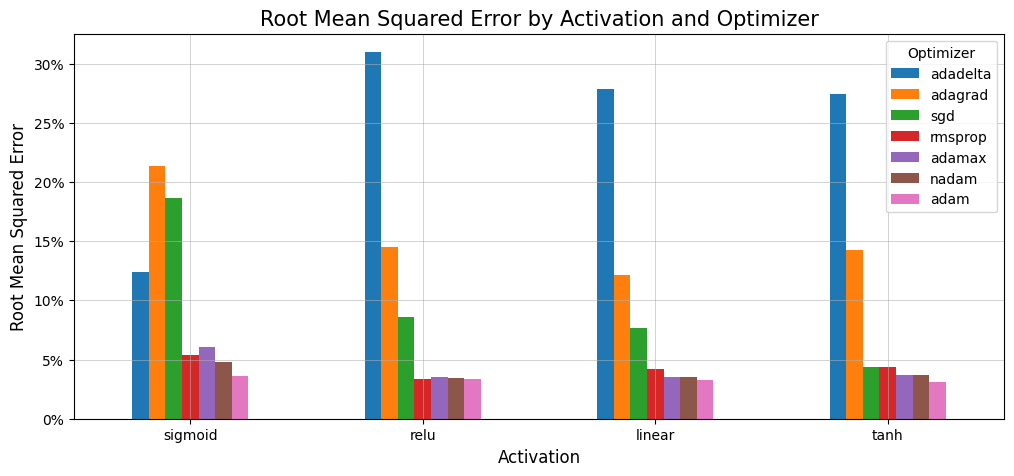

In [109]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_rmse = df_result.pivot_table(index='Activation', columns='Optimizer', values='RMSE (%)')
# Sort the columns based on the mean RMSE value
df_rmse = df_rmse[df_rmse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_rmse = df_rmse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_rmse = df_rmse.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_rmse.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=12)
ax.set_title('Root Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

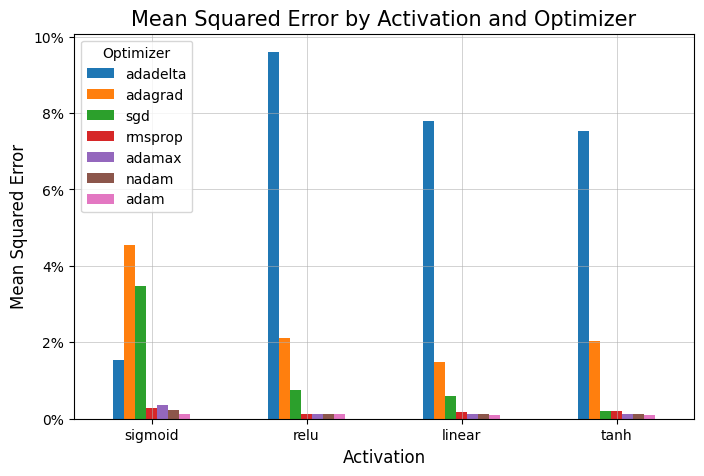

In [110]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mse = df_result.pivot_table(index='Activation', columns='Optimizer', values='MSE (%)')
# Sort the columns based on the mean MSE value
df_mse = df_mse[df_mse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mse = df_mse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MSE value
df_mse = df_mse.sort_values(by=df_mse.columns[-1], ascending=False)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_mse.plot(kind='bar', ax=ax) # modified line
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Squared Error', fontsize=12) # modified line
ax.set_title('Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

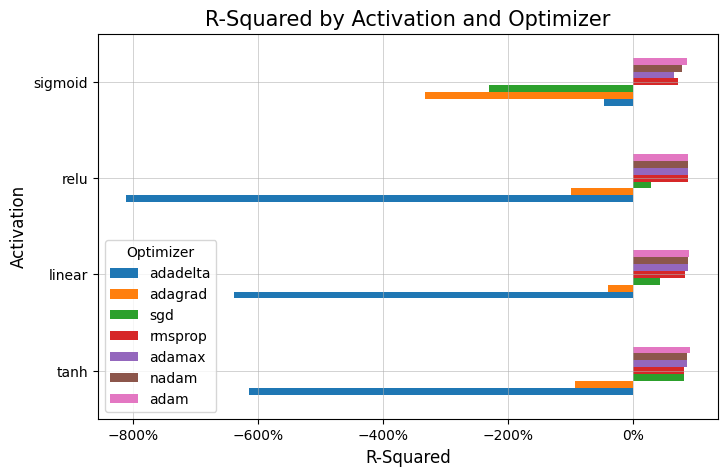

In [111]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_r2 = df_result.pivot_table(index='Activation', columns='Optimizer', values='R-Squared (%)')
# Sort the columns based on the mean R2 value
df_r2 = df_r2[df_r2.mean().sort_values(ascending=True).index]
# Sort the rows based on the activation function
df_r2 = df_r2.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean R2 value
df_r2 = df_r2.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_r2.plot(kind='barh', ax=ax)
ax.set_xlabel('R-Squared', fontsize=12)
ax.set_ylabel('Activation', fontsize=12)
ax.set_title('R-Squared by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()